In [1]:
#Dependencies
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.data import DataLoader
import itertools
import torch
from offline_env import OfflineEnv
import os

import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares
                                                            
import os 

from collections import defaultdict
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchtools.optim import Ranger
# from ranger import Ranger
from adabelief_pytorch import AdaBelief

import adabelief_pytorch
import tqdm
import random
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity as cs
import seaborn as sns

ModuleNotFoundError: No module named 'offline_env'

## 1. 데이터 불러오기

In [ ]:
datapath = './data_final.csv'
columns =  ['item', 'user', 'rating', 'timestamp']
df = pd.read_csv(datapath, sep = ",", names = columns, dtype = int)
df.astype(int)
df.head()

In [3]:
users_df = df.sort_values(["user","timestamp"]).set_index("user").fillna(0).drop("timestamp",axis=1)
users = dict(tuple(df.groupby("user"))) 

In [4]:
print(df.shape)

(13361842, 4)


In [5]:
df['user'].nunique()

258582

In [6]:
df['item'].nunique()

637911

In [24]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = df['user'].unique()
item_unique = df['item'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
idx_to_user = {k:v for k,v in enumerate(user_unique)}
item_to_idx = {v:k for k,v in enumerate(item_unique)}
idx_to_item = {k:v for k,v in enumerate(item_unique)}

In [8]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = df['user'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(df):   # 모든 row가 정상적으로 인덱싱되었다면
    print('userId column indexing OK!!')
    df['user'] = temp_user_data   # data['userId']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('userId column indexing Fail!!')

# movie_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_item_data = df['item'].map(item_to_idx.get).dropna()
if len(temp_item_data) == len(df):
    print('itemId column indexing OK!!')
    df['item'] = temp_item_data
else:
    print('itemId column indexing Fail!!')
# up_data

userId column indexing OK!!
itemId column indexing OK!!


In [13]:
num_user = df['user'].nunique()
num_item = df['item'].nunique()

csr_data = csr_matrix((df['rating'], (df.user, df.item)), shape= (num_user, num_item))

In [14]:
#num_threads=-1
als_model = AlternatingLeastSquares(factors=100, regularization=0.01,use_gpu=False,
                                    iterations=15,dtype=np.float32,calculate_training_loss=True, num_threads=1)

#item x user
csr_data_transpose = csr_data.T
# csr_data_transpose
als_model.fit(csr_data_transpose)

In [15]:
item_embeddings_dict = {idx_to_item[i]:tf.convert_to_tensor(als_model.item_factors[i]) for i in tqdm.tqdm(range(num_item))}
user_embeddings_dict = {idx_to_user[i]:tf.convert_to_tensor(als_model.user_factors[i]) for i in tqdm.tqdm(range(num_user))}

len(user_embeddings_dict)

100%|██████████| 258582/258582 [00:02<00:00, 112341.97it/s]


258582

In [16]:
len(item_embeddings_dict)

637911

In [9]:
item_embeddings_dict = np.load("./item_embeddings_dict_final_1.npy", allow_pickle=True).item()
user_embeddings_dict = np.load("./user_embeddings_dict_final_1.npy", allow_pickle=True).item()

In [10]:
# np.save("item_embeddings_dict_final_1.npy", item_embeddings_dict)
# np.save("user_embeddings_dict_final_1.npy", user_embeddings_dict)

## 2. Train and Test Dataset

In [11]:
#Getting users with positive rating count greater than 10 
# 10 == 'N' positively interacted items
# from collections import defaultdict
# from collections import Counter
users_dict = defaultdict(dict)
users_id_list = set()
for user_id in users:
    rating_freq = Counter(users[user_id]["rating"].values)
    if rating_freq[4]+rating_freq[5]<10 :
        continue    
    else:
        users_id_list.add(int(user_id))
        users_dict[user_id]["item"] = users[user_id]["item"].values
        users_dict[user_id]["rating"] = users[user_id]["rating"].values

In [12]:
users_dict[14680070]["rating"]

array([5, 1, 2, 2, 2, 4, 4, 3, 4, 3, 5, 5, 3, 4, 5, 4, 5, 5, 4, 2, 1, 2,
       2, 2, 4, 5, 4, 1, 2, 4, 4, 3, 5, 4, 4, 5, 5, 1, 5])

In [13]:
users_id_list = np.array(list(users_id_list))
print(users_id_list)

[12058627 14680070  7340040 ...  9437172 12058615 11010043]


In [14]:
print(users_dict[12058627])

{'item': array([  28067,   41744,   81990,   94755,   95277,  104841,  122183,
        177661,  180581,  183115,  211122,  233553,  271914,  284884,
        286968,  300146,  339862,  343635,  364176,  364388,  364375,
        411644,  445202,  463239,  512989,  632956,  723559,  755129,
        809664,  819077,  819739,  878301,  951090, 1009123, 1010557,
       1042421, 1071233, 1107949, 1112160, 1125199, 1341839, 1347405,
       1487939, 1514645, 1580541, 1928572, 1956531, 1956306, 1962144,
       1972774, 1983891, 2009311, 2015798, 2031750, 2098284, 2127133,
       2233093, 2285383, 2295964, 2295969, 2295970, 2301303, 2305905,
       2388411, 2390438, 2542197,  527007, 2791251,  180670,  199910,
        271858,  293239,  441781,  538337,  544191,  766746,  955067,
        962416, 1010621, 1025036, 1151374, 1181909, 1889954, 2108769]), 'rating': array([4, 5, 4, 4, 5, 5, 3, 4, 5, 4, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 1, 5,
       5, 5, 4, 5, 5, 5, 1, 4, 5, 5, 5, 4, 5, 4, 5, 2, 5, 5, 4, 5,

In [15]:
len(users_id_list)

254330

In [16]:
#choosing default train_test_split of 25%
train_users,test_users = train_test_split(users_id_list)
print(train_users[:2])

[14198794 14087016]


In [17]:
print(test_users[:2])

[11076733 11498788]


In [25]:
from torch.utils.data import Dataset
class UserDataset(Dataset):
    def __init__(self,users_list,users_dict):
        self.users_list = users_list
        self.users_dict = users_dict

    def __len__(self):
        return len(self.users_list)

    def __getitem__(self,idx):
        user_id = self.users_list[idx]
        items = [('1',)]*10
        ratings = [('0',)]*10
        j=0
        for i,rate in enumerate(self.users_dict[user_id]["rating"]):
            if int(rate) >3 and j < 10:
                items[j] = self.users_dict[user_id]["item"][i]
                ratings[j] = self.users_dict[user_id]["rating"][i]
                j += 1
        # item = list(self.users_dict[user_id]["item"][:])
        # rating = list(self.users_dict[user_id]["rating"][:])
        size = len(items)
    
        return {'item':items,'rating':ratings,'size':size,'userid':user_id,'idx':idx}

In [26]:
train_users_dataset = UserDataset(train_users,users_dict)
test_users_dataset = UserDataset(test_users,users_dict)

In [27]:
train_dataloader = DataLoader(train_users_dataset, batch_size=1)
test_dataloader = DataLoader(test_users_dataset, batch_size=1)

In [21]:
train_num = len(train_dataloader)
print(train_num)

190747


In [22]:
test_num = len(test_dataloader)
print(test_num)

63583


## 3. State Representation Models¶

### DDR-ave

In [176]:
''' input
    # dataloader에서 나온 return들
    # user_idb : 해당 user의 id 
    # itemb : 유저가 rating 한 item id 10개(tensor))
    # memory :  유저가 rating 한 item들 list 크기는 유저 * 10(item)  
    idx : user_list에서 user의 index
    output
    state : #state tensor shape [21,100]
'''
def drrave_state_rep(userid_b, memory, idx):
    user_num = idx
    H = [] #item embeddings
    user_n_items = memory
    user_embeddings = torch.Tensor(np.array(user_embeddings_dict[int(userid_b[0])]),).unsqueeze(0)
#     print("user_n_items", user_n_items)
#     print("user_n_items", len(user_n_items))
    for item in user_n_items:
        H.append(np.array(item_embeddings_dict[int(item)]))
    avg_layer = nn.AvgPool1d(1)  # pooling layer 사용 
    item_embeddings = avg_layer(torch.Tensor(H,).unsqueeze(0)).permute(0,2,1).squeeze(0)
    #print('item_embedding.size: ', item_embeddings.size())
    #print('item_embedding_no permute: ', item_embeddings)
    #print('item_embedding_no permute_T: ', item_embeddings.T)
    #item_embeddings_permute = avg_layer(torch.Tensor(H,).unsqueeze(0)).permute(0,2,1).squeeze(0)
    #print('item_embedding_permute: ', item_embeddings)
    #print('item_embedding.size: ', item_embeddings.size()) 
    #print(item_embeddings)
    #assert (item_embeddings == item_embeddings_permute.T).any()
    state = torch.cat([user_embeddings,user_embeddings*item_embeddings.T,item_embeddings.T])
    #print('state.size: ', state.size())
    #print('user_embedding.size: ', user_embeddings.size())
    # permute => transpose
    return state #state tensor shape [21,100] 

### DRR-u

In [165]:
# def drru_state_rep(userid_b,items,memory,idx):
#     user_num = idx
#     H = []
#     user_n_items = items
#     user_embeddings = user_embeddings_dict[userid_b[0]]
#     for i,item in enumerate(user_n_items):
#         ui = np.array(user_embeddings) * np.array(movie_embeddings_dict[item[0]])
#         H.append(ui)

#     pairs = list(itertools.combinations(memory[user_num], 2))
#     for item1,item2 in pairs:
#         pair1 =  np.array(movie_embeddings_dict[str(int(item1))])
#         pair2 = np.array(movie_embeddings_dict[str(int(item2))])

#         product = pair1*pair2
#         H.append(product)
#     state = torch.Tensor(H,)
#     return state #state tensor shape [55,100]


### DRR-p

In [30]:
# def drrp_state_rep(items,memory,idx):
#   user_num = idx
#   H = []
#   user_n_items = items
#   for i,item in enumerate(user_n_items):
#     H.append(np.array(movie_embeddings_dict[item[0]]))
  
#   pairs = list(itertools.combinations(memory[user_num], 2))
#   for item1,item2 in pairs:
#     pair1 =  np.array(movie_embeddings_dict[str(int(item1))])
#     pair2 = np.array(movie_embeddings_dict[str(int(item2))])
#     product = pair1*pair2
#     H.append(product)
#   state = torch.Tensor(H,)
#   return state

### state-rep

In [31]:
# just n items and their embeddings used to represent state
'''
def state_rep(item_b):
    state = []
    user_embeddings = np.zeros((len(columns),100))
    item_ids = list(item[0] for item in item_b)
    for i,subitem in enumerate(user_embeddings):
        if idx_to_id[i] in item_ids:
            user_embeddings[i] = np.array(item_embeddings_dict[idx_to_id[i]])
        else:
            user_embeddings[i] = np.zeros((100,))
    state = torch.Tensor(user_embeddings,)
    return torch.reshape(state,[-1]) 
'''

'\ndef state_rep(item_b):\n    state = []\n    user_embeddings = np.zeros((len(columns),100))\n    item_ids = list(item[0] for item in item_b)\n    for i,subitem in enumerate(user_embeddings):\n        if idx_to_id[i] in item_ids:\n            user_embeddings[i] = np.array(item_embeddings_dict[idx_to_id[i]])\n        else:\n            user_embeddings[i] = np.zeros((100,))\n    state = torch.Tensor(user_embeddings,)\n    return torch.reshape(state,[-1]) \n'

## 4. Actor, Critic 

In [32]:
# !pip install git+https://github.com/pabloppp/pytorch-tools@0.2.4 -U

In [73]:
#Actor Model:
#Generating an action a based on state s

# Input_dim 5500, output_dim 100, hidden_dim 256 for drr-u, p
# Input_dim 2100, output_dim 100, hidden_dim 256 for drr-ave

# embedding을 normalize(-1, 1) => tanh
# embedding을 standard scaling => PCA whitening

class Actor(torch.nn.Module):
    def __init__(self, input_dim, output_dim,hidden_dim):
        super(Actor, self).__init__()

        self.drop_layer = nn.Dropout(p=0.5)        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state):
        x = F.relu(self.linear1(state.to(device)))
        # print(x.shape)
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        # print(x.shape)
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x # state = self.state_rep(state) 

In [74]:
class Critic(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim):

        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
    
        self.linear1 = nn.Linear(input_dim + output_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

    def forward(self,state,action):    
        x = torch.cat([state.to(device), action.to(device)], 1)
        # print(x.shape)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

    PER buffer

In [75]:
''' PER Replaybuffer '''

import numpy as np
from segment_tree import MinSegmentTree, SumSegmentTree # This is baseline provided in OpenAI.

# Naive ReplayBuffer
class ReplayBuffer:
    """ Experience Replay Buffer which is implemented in DQN paper. https://www.nature.com/articles/nature14236 
    The detailed parameter is described in each method.
    """

    def __init__(self, 
                 buffer_size: ('int: total size of the Replay Buffer'), 
                 input_dim: ('int: a dimension of input data'),
                 action_dim: ('int: a dimension of action'),
                 batch_size: ('int: a batch size when updating')):

        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.save_count, self.current_size = 0, 0

        self.state_buffer = np.ones((buffer_size, input_dim), dtype=np.float32) 
        self.action_buffer = np.ones((buffer_size, action_dim), dtype=np.float32) 
        self.reward_buffer = np.ones(buffer_size, dtype=np.float32) 
        self.next_state_buffer = np.ones((buffer_size, input_dim), dtype=np.float32) 
        self.done_buffer = np.ones(buffer_size, dtype=np.int8)  

    def store(self, 
              state: np.float32, 
              action: np.float32, 
              reward: np.float32, 
              next_state: np.float32, 
              done: np.int8):

        self.state_buffer[self.save_count] = state
        self.action_buffer[self.save_count] = action
        self.reward_buffer[self.save_count] = reward
        self.next_state_buffer[self.save_count] = next_state
        self.done_buffer[self.save_count] = done

        self.save_count = (self.save_count + 1) % self.buffer_size
        self.current_size = min(self.current_size+1, self.buffer_size)

    def batch_load(self):
        indices = np.random.randint(self.current_size, size=self.batch_size)
        return dict(
                states=self.state_buffer[indices], 
                actions=self.action_buffer[indices],
                rewards=self.reward_buffer[indices],
                next_states=self.next_state_buffer[indices], 
                dones=self.done_buffer[indices]) 

# ReplayBuffer for Prioritized Experience Replay. 
class PrioritizedReplayBuffer(ReplayBuffer):
    
    def __init__(self, buffer_size, input_dim, action_dim, batch_size, alpha):
        
        super(PrioritizedReplayBuffer, self).__init__(buffer_size, input_dim, action_dim, batch_size)
        
        # For PER. Parameter settings. 
        self.max_priority, self.tree_idx = 1.0, 0
        self.alpha = alpha

        tree_capacity = 1
        while tree_capacity < self.buffer_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        
    def store(self, 
              state: np.float32, 
              action: np.float32, 
              reward: np.float32, 
              next_state: np.ndarray, 
              done: np.int8):
        
        super().store(state, action, reward, next_state, done)
        
        self.sum_tree[self.tree_idx] = self.max_priority ** self.alpha
        self.min_tree[self.tree_idx] = self.max_priority ** self.alpha
        self.tree_idx = (self.tree_idx + 1) % self.buffer_size

    def batch_load(self, beta):
        
        indices, p_total = self._sample_indices_with_priority()
        weights = self._cal_weight(indices, p_total, self.current_size, beta)
        return dict(
                states=self.state_buffer[indices], 
                actions=self.action_buffer[indices],
                rewards=self.reward_buffer[indices],
                next_states=self.next_state_buffer[indices], 
                dones=self.done_buffer[indices],
                weights=weights,
                indices=indices) 

    def update_priorities(self, indices, priorities):
        
        for idx, priority in zip(indices, priorities.flatten()):
            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha
            
            self.max_priority = max(self.max_priority, priority)
    
    def _sample_indices_with_priority(self):

        p_total = self.sum_tree.sum() 
        segment = p_total / self.batch_size
        segment_list = [i*segment for i in range(self.batch_size)]
        samples = [np.random.uniform(a, a+segment) for a in segment_list]
        indices = [self.sum_tree.find_prefixsum_idx(sample) for sample in samples]
        
        return indices, p_total
    
    def _cal_weight(self, indices, p_total, N, beta):
        
        p_min = self.min_tree.min() / p_total
        max_weight = (p_min*N) ** (-beta) 
        
        p_samples = np.array([self.sum_tree[idx] for idx in indices]) / p_total
        weights = (p_samples*N)**(-beta)/max_weight
        return weights
    
if __name__=='__main__':
    buffer_size = 100
    input_dim = 2100
    action_dim = 100
    batch_size = 16
    alpha = 0.6
    beta = 0.4
    buffer = PrioritizedReplayBuffer(buffer_size, input_dim, action_dim, batch_size, alpha)
    for i in range(50):
        state = np.ones(input_dim)
        action = 1
        reward = 1
        next_state = np.ones(input_dim)
        done = 1
        buffer.store(state, action, reward, next_state, done)
    print(buffer.alpha)
    print(buffer.max_priority)
    print(buffer.batch_load(beta)['states'].shape)
    print(buffer.batch_load(beta)['actions'].shape)
    print(buffer.batch_load(beta)['rewards'].shape)
    print(buffer.batch_load(beta)['next_states'].shape)
    print(buffer.batch_load(beta)['dones'].shape)
    print(buffer.batch_load(beta)['weights'].shape)
    print(buffer.batch_load(beta)['indices'].__len__())

0.6
1.0
(16, 2100)
(16, 100)
(16,)
(16, 2100)
(16,)
(16,)
16


In [76]:
'''
state = drrave_state_rep(userid_b,item_b,memory,idx_b)
state_rep =  torch.reshape(state,[-1])
next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
next_state_rep = torch.reshape(next_state,[-1])
#R.push(state_rep.detach().cpu().numpy(), action_emb.detach().cpu().numpy(), reward, next_state_rep.detach().cpu().numpy()
)
'''

'\nstate = drrave_state_rep(userid_b,item_b,memory,idx_b)\nstate_rep =  torch.reshape(state,[-1])\nnext_state = drrave_state_rep(userid_b,item_b,memory,idx_b)\nnext_state_rep = torch.reshape(next_state,[-1])\n#R.push(state_rep.detach().cpu().numpy(), action_emb.detach().cpu().numpy(), reward, next_state_rep.detach().cpu().numpy()\n)\n'

In [77]:
# device = 'cpu'
device = torch.device('cuda:1')

In [78]:
#used for plotting purposes
p_loss = []
v_loss = []

In [79]:
def ddpg_update(batch_size=32, 
                gamma = 0.6,
                min_value=-np.inf,
                max_value=np.inf,
                soft_tau=1e-2,
                beta=0.4):
    
    batch = replay_buffer.batch_load(beta)
    weights = torch.FloatTensor(batch['weights'].reshape(-1, 1)).to(device) # device 는 GPU 번호
    states = torch.FloatTensor(batch['states']).to(device)
    next_states = torch.FloatTensor(batch['next_states']).to(device)
    actions = torch.FloatTensor(batch['actions']).to(device)
    rewards = torch.FloatTensor(batch['rewards'].reshape(-1, 1)).to(device)
    dones = torch.FloatTensor(batch['dones'].reshape(-1, 1)).to(device)
    
    # policy loss
    policy_loss = -(weights * value_net(states, policy_net(states))).mean()
    p_loss.append(policy_loss) 
    
    # value loss
    # print(states.shape)
    # print(actions.shape)
    value = value_net(states, actions)
    next_actions   = target_policy_net(next_states) 
    mask = 1 - dones
    expected_value = (rewards + gamma * mask * target_value_net(next_states, next_actions.detach())).to(device) 
    expected_value = torch.clamp(expected_value, min_value, max_value) 
    sample_wise_loss = F.smooth_l1_loss(value, expected_value.detach(), reduction="none") 
        
    value_loss = (weights * sample_wise_loss).mean()
    v_loss.append(value_loss)
    
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
    
    # For PER: update priorities of the samples.
    epsilon_for_priority = 1e-8
    sample_wise_loss = sample_wise_loss.detach().cpu().numpy()
    batch_priorities = sample_wise_loss + epsilon_for_priority
    replay_buffer.update_priorities(batch['indices'], batch_priorities)

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)


In [80]:
# #initializing actor and critic networks for drru and drrp state representation

# value_net = Critic(5500,100,256).to(device)
# policy_net = Actor(5500,100,256).to(device)

# target_value_net = Critic(5500,100,256).to(device)
# target_policy_net = Actor(5500,100,256).to(device)

    
# target_policy_net.eval()
# target_value_net.eval()

# for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
#     target_param.data.copy_(param.data)

# for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
#     target_param.data.copy_(param.data)

# value_criterion = nn.MSELoss()
# value_optimizer      = Ranger(value_net.parameters(),  lr=1e-4)
# policy_optimizer     = Ranger(policy_net.parameters(), lr=1e-4)

In [81]:
#initializing for drrave state representation

value_net = Critic(2100,100,256).to(device)
policy_net = Actor(2100,100,256).to(device)

target_value_net = Critic(2100,100,256).to(device)
target_policy_net = Actor(2100,100,256).to(device)

target_policy_net.eval()
target_value_net.eval()

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)

value_criterion = nn.MSELoss()
value_optimizer = AdaBelief(value_net.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)
policy_optimizer = AdaBelief(policy_net.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled

In [82]:
buffer_size = 500000
replay_buffer = PrioritizedReplayBuffer(buffer_size, input_dim, action_dim, batch_size, alpha)
memory = np.ones((train_num,10))*-1

In [148]:
torch.sort??

In [214]:
def get_action(state, action_emb, userid_b, items):
    action_emb = torch.reshape(action_emb,[1,100]).unsqueeze(0).to(device)
    m = torch.bmm(action_emb,items).squeeze(0)  #torch.bmm : batch 행렬 곱연산
    _, indices = torch.sort(m, descending=True)
    index_list = list(indices[0])
    for i in index_list: 
        if users_dict[int(userid_b[0])]["item"][i] not in preds:     
            preds.add(users_dict[int(userid_b[0])]["item"][i]) 
            return int(i) 

In [206]:
def update_memory(memory,action,idx):
    memory[idx] = list(memory[idx,1:])+[action]

In [45]:
rate = 0

In [46]:
it = iter(train_dataloader)
first = next(it)
item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
print(item_b)

[tensor([573887]), tensor([1254841]), tensor([1501510]), tensor([1501478]), tensor([1596782]), tensor([1677577]), tensor([1677584]), tensor([1683762]), tensor([1698998]), tensor([1712321])]


In [47]:
first = next(it)
item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
print(item_b)

[tensor([2450]), tensor([2624]), tensor([3744]), tensor([4072]), tensor([14346]), tensor([22548]), tensor([28679]), tensor([32324]), tensor([67334]), tensor([92355])]


In [48]:
first['rating']

[tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([4]),
 tensor([5]),
 tensor([5]),
 tensor([4]),
 tensor([4]),
 tensor([5]),
 tensor([5])]

In [49]:
print(int(userid_b[0]))

14087016


In [50]:
memory = np.ones((train_num,10))*-1
drrave_state_rep(userid_b,item_b,memory,idx_b)

tensor([[ 1.1038e-02, -1.2569e-02,  2.3547e-02,  ...,  1.7134e-02,
         -1.8365e-02, -1.6432e-02],
        [ 2.9413e-04, -2.5749e-04,  2.0463e-03,  ...,  1.5012e-05,
         -5.8687e-04,  1.3237e-04],
        [ 4.0714e-05, -4.1369e-05,  1.2574e-04,  ...,  4.4806e-05,
         -1.2691e-05,  1.0757e-05],
        ...,
        [ 2.2914e-02,  2.2303e-02,  1.6147e-02,  ...,  7.3412e-04,
          1.7213e-02, -6.4322e-03],
        [ 3.3489e-02,  1.2126e-01,  1.1940e-01,  ...,  1.6545e-01,
         -2.9338e-01, -4.8589e-02],
        [ 2.4350e-02,  2.2090e-02,  5.1682e-02,  ..., -1.4921e-02,
          3.7018e-02, -6.3500e-03]])

In [51]:
print(item_b[1])

tensor([2624])


In [52]:
memory = np.ones((train_num,10))*-1
memory[idx_b] = [item[0] for item in item_b]
print(memory[idx_b])

[ 2450.  2624.  3744.  4072. 14346. 22548. 28679. 32324. 67334. 92355.]


In [53]:
print(item_b[1][0])

tensor(2624)


In [54]:
print(memory)

[[-1.0000e+00 -1.0000e+00 -1.0000e+00 ... -1.0000e+00 -1.0000e+00
  -1.0000e+00]
 [ 2.4500e+03  2.6240e+03  3.7440e+03 ...  3.2324e+04  6.7334e+04
   9.2355e+04]
 [-1.0000e+00 -1.0000e+00 -1.0000e+00 ... -1.0000e+00 -1.0000e+00
  -1.0000e+00]
 ...
 [-1.0000e+00 -1.0000e+00 -1.0000e+00 ... -1.0000e+00 -1.0000e+00
  -1.0000e+00]
 [-1.0000e+00 -1.0000e+00 -1.0000e+00 ... -1.0000e+00 -1.0000e+00
  -1.0000e+00]
 [-1.0000e+00 -1.0000e+00 -1.0000e+00 ... -1.0000e+00 -1.0000e+00
  -1.0000e+00]]


In [55]:
print(idx_b)

tensor([1])


## 5. Training

In [90]:
OfflineEnv??

In [211]:
class OfflineEnv2:

    def __init__(self, dataloader, users_dict, item_embeddings_dict):
        
        self.dataloader = iter(dataloader)
        self.users_dict = users_dict
        
        self.data = next(self.dataloader) # {'item':items,'rating':ratings,'size':size,'userid':user_id,'idx':idx}
        self.user_history = self.users_dict[int(self.data['userid'])]
        
        self.item_embedding = torch.Tensor([np.array(item_embeddings_dict[item]) for item in users_dict[int(self.data['userid'][0])]['item']])
        self.items = self.item_embedding.T.unsqueeze(0)

        self.memory = [item[0] for item in self.data['item']]
        self.done = 0

        self.related_books = self.generate_related_books()
        self.viewed_pos_books = []
    
    def generate_related_books(self):
        related_movie = []
        items = self.user_history['item'][10:]
        ratings = self.user_history['rating'][10:]

        for item, rating in zip(items, ratings):
            if rating > 3:
                related_movie.append(item)
        
        return related_movie

    def reset(self):
        self.data = next(self.dataloader)
        self.memory = [item[0] for item in self.data['item']]
        self.user_history = self.users_dict[int(self.data['userid'])]
        self.done = 0
        self.item_embedding = torch.Tensor([np.array(item_embeddings_dict[item]) for item in users_dict[int(self.data['userid'][0])]['item']])
        self.items = self.item_embedding.T.unsqueeze(0)
        self.related_books = self.generate_related_books()
        self.viewed_pos_books = []

    def update_memory(self,action):
        self.memory = list(self.memory[1:]) + [self.user_history['item'][action]]
        
    def step(self, action):
        
        ### Env : step
        ### 
        rating = int(self.user_history["rating"][action])
        normal_rating = (int(rating)-3)/2
        reward = torch.Tensor((normal_rating,))
        #ep_reward = ep_reward + ratings

        if reward > 0:
            self.update_memory(action)
            self.viewed_pos_books.append(action)
    
        if len(self.viewed_pos_books) == len(self.related_books):
            self.done = 1
        
        return self.memory, reward, self.done


In [219]:
len(env.user_history['item'])

60

In [ ]:
env = OfflineEnv2(train_dataloader, users_dict, item_embeddings_dict)
preddict = dict()
accum_rewards = []
for episode in tqdm.tqdm(range(train_num-1)):
    ep_reward = 0
    batch_size= 16

    item_b, rating_b, size_b, userid_b, idx_b = env.data['item'], env.data['rating'], env.data['size'], env.data['userid'], env.data['idx']
    memory = env.memory
    preds = set(item_b)
    state = drrave_state_rep(userid_b,memory,idx_b)
    items = env.items.to(device)
    
    done = 0
    user_len = len(env.user_history['item'])
    print("User Length", user_len)
    while not done:    
        state_rep =  torch.reshape(state,[-1])
        action_emb = policy_net(state_rep)
        action = get_action(state, action_emb, userid_b, items)
        
        memory, reward, done = env.step(action)
    
        ep_reward += reward
        next_state = drrave_state_rep(userid_b, memory, idx_b)
        next_state_rep = torch.reshape(next_state,[-1])

        replay_buffer.store(state_rep.detach().cpu().numpy(), 
                            action_emb.detach().cpu().numpy(), 
                            reward, next_state_rep.detach().cpu().numpy(), done)
        if replay_buffer.current_size > batch_size:
            ddpg_update(batch_size=batch_size)

        state = next_state
    env.reset()
    accum_rewards.append(ep_reward)
    preddict[userid_b[0]] = preds
#     if episode%50==0:
#         plt.figure(facecolor='w')
#         plt.plot(accum_rewards)
    

  0%|          | 0/190746 [00:00<?, ?it/s]

User Length 60


  0%|          | 3/190746 [00:00<13:56:53,  3.80it/s]

User Length 29
User Length 23
User Length 82


  0%|          | 6/190746 [00:01<13:37:20,  3.89it/s]

User Length 22
User Length 32
User Length 33


  0%|          | 8/190746 [00:01<9:59:51,  5.30it/s] 

User Length 27
User Length 25
User Length 25


  0%|          | 11/190746 [00:01<8:18:06,  6.38it/s]

User Length 37
User Length 31


  0%|          | 13/190746 [00:01<7:39:44,  6.91it/s]

User Length 42
User Length 22
User Length 1148


  0%|          | 15/190746 [00:19<144:27:48,  2.73s/it]

User Length 68


  0%|          | 18/190746 [00:20<75:54:32,  1.43s/it] 

User Length 20
User Length 32
User Length 32


  0%|          | 21/190746 [00:20<40:05:12,  1.32it/s]

User Length 23
User Length 28
User Length 212


  0%|          | 24/190746 [00:22<39:29:49,  1.34it/s]

User Length 25
User Length 19
User Length 21
User Length 31


  0%|          | 27/190746 [00:22<21:58:21,  2.41it/s]

User Length 26
User Length 342


  0%|          | 29/190746 [00:25<44:52:46,  1.18it/s]

User Length 30
User Length 31


  0%|          | 30/190746 [00:25<33:27:55,  1.58it/s]

User Length 58


  0%|          | 31/190746 [00:25<28:16:33,  1.87it/s]

User Length 67


  0%|          | 32/190746 [00:26<25:39:25,  2.06it/s]

User Length 47


  0%|          | 33/190746 [00:26<21:48:14,  2.43it/s]

User Length 141


  0%|          | 34/190746 [00:27<29:39:45,  1.79it/s]

User Length 216


  0%|          | 36/190746 [00:29<35:12:00,  1.50it/s]

User Length 31
User Length 23


  0%|          | 38/190746 [00:29<26:27:52,  2.00it/s]

User Length 30
User Length 46


  0%|          | 39/190746 [00:29<22:16:30,  2.38it/s]

User Length 21
User Length 35


  0%|          | 41/190746 [00:29<17:25:14,  3.04it/s]

User Length 70


  0%|          | 43/190746 [00:30<15:17:17,  3.46it/s]

User Length 37
User Length 26


  0%|          | 45/190746 [00:30<12:13:03,  4.34it/s]

User Length 26
User Length 21
User Length 22


  0%|          | 48/190746 [00:30<9:31:07,  5.56it/s] 

User Length 35
User Length 42


  0%|          | 49/190746 [00:31<10:08:27,  5.22it/s]

User Length 47


  0%|          | 50/190746 [00:31<10:49:56,  4.89it/s]

User Length 186


  0%|          | 53/190746 [00:32<19:50:29,  2.67it/s]

User Length 20
User Length 20
User Length 20
User Length 24


  0%|          | 56/190746 [00:33<12:46:19,  4.15it/s]

User Length 31
User Length 49


  0%|          | 58/190746 [00:33<11:43:16,  4.52it/s]

User Length 39
User Length 44


  0%|          | 61/190746 [00:33<9:18:42,  5.69it/s] 

User Length 25
User Length 21
User Length 26
User Length 48


  0%|          | 65/190746 [00:34<7:25:30,  7.13it/s]

User Length 20
User Length 29
User Length 49


  0%|          | 66/190746 [00:34<8:36:45,  6.15it/s]

User Length 68


  0%|          | 68/190746 [00:34<10:10:11,  5.21it/s]

User Length 30
User Length 68


  0%|          | 71/190746 [00:35<10:02:54,  5.27it/s]

User Length 22
User Length 24
User Length 117


  0%|          | 74/190746 [00:36<13:44:08,  3.86it/s]

User Length 23
User Length 20
User Length 29


  0%|          | 76/190746 [00:36<10:12:01,  5.19it/s]

User Length 31
User Length 21
User Length 20


  0%|          | 80/190746 [00:36<7:02:08,  7.53it/s] 

User Length 27
User Length 20
User Length 34


  0%|          | 82/190746 [00:37<6:39:07,  7.96it/s]

User Length 23
User Length 22
User Length 40


  0%|          | 84/190746 [00:37<6:26:23,  8.22it/s]

User Length 88


  0%|          | 86/190746 [00:37<9:25:49,  5.62it/s]

User Length 27
User Length 94


  0%|          | 87/190746 [00:38<18:11:56,  2.91it/s]

User Length 372


  0%|          | 90/190746 [00:41<45:17:08,  1.17it/s]

User Length 23
User Length 21
User Length 26
User Length 49


  0%|          | 92/190746 [00:42<34:14:57,  1.55it/s]

User Length 58


  0%|          | 94/190746 [00:42<22:34:11,  2.35it/s]

User Length 36
User Length 66


  0%|          | 97/190746 [00:43<16:02:50,  3.30it/s]

User Length 22
User Length 22
User Length 25
User Length 138


  0%|          | 99/190746 [00:44<19:24:36,  2.73it/s]

User Length 231


  0%|          | 100/190746 [00:46<42:22:47,  1.25it/s]

User Length 297


  0%|          | 101/190746 [00:48<66:24:56,  1.25s/it]

User Length 29
User Length 31


  0%|          | 103/190746 [00:48<48:19:19,  1.10it/s]

User Length 63


  0%|          | 104/190746 [00:48<40:01:39,  1.32it/s]

User Length 51


  0%|          | 106/190746 [00:49<25:18:32,  2.09it/s]

User Length 31
User Length 28


  0%|          | 107/190746 [00:49<19:56:00,  2.66it/s]

User Length 21
User Length 34


  0%|          | 110/190746 [00:49<13:12:22,  4.01it/s]

User Length 24
User Length 97


  0%|          | 113/190746 [00:50<14:11:35,  3.73it/s]

User Length 24
User Length 24
User Length 56


  0%|          | 114/190746 [00:50<14:18:13,  3.70it/s]

User Length 48


  0%|          | 116/190746 [00:51<11:50:34,  4.47it/s]

User Length 33
User Length 21


  0%|          | 118/190746 [00:51<9:20:14,  5.67it/s] 

User Length 21
User Length 26
User Length 51


  0%|          | 120/190746 [00:51<9:13:20,  5.74it/s]

User Length 23
User Length 32


  0%|          | 123/190746 [00:52<8:21:03,  6.34it/s]

User Length 31
User Length 21
User Length 20


  0%|          | 125/190746 [00:52<6:48:00,  7.79it/s]

User Length 40


  0%|          | 127/190746 [00:52<6:54:41,  7.66it/s]

User Length 20
User Length 21
User Length 29


  0%|          | 129/190746 [00:52<6:20:08,  8.36it/s]

User Length 56


  0%|          | 131/190746 [00:53<8:32:51,  6.19it/s]

User Length 36
User Length 74


  0%|          | 132/190746 [00:53<12:33:53,  4.21it/s]

User Length 77


  0%|          | 133/190746 [00:54<15:19:24,  3.46it/s]

User Length 65


  0%|          | 134/190746 [00:54<17:28:15,  3.03it/s]

User Length 54


  0%|          | 135/190746 [00:54<17:11:48,  3.08it/s]

User Length 61


  0%|          | 136/190746 [00:55<18:08:16,  2.92it/s]

User Length 20
User Length 42


  0%|          | 138/190746 [00:55<15:16:07,  3.47it/s]

User Length 40


  0%|          | 140/190746 [00:55<13:00:46,  4.07it/s]

User Length 40
User Length 27


  0%|          | 141/190746 [00:56<10:51:16,  4.88it/s]

User Length 108


  0%|          | 143/190746 [00:56<13:49:41,  3.83it/s]

User Length 23
User Length 47


  0%|          | 144/190746 [00:57<13:39:56,  3.87it/s]

User Length 20
User Length 28


  0%|          | 148/190746 [00:57<8:51:57,  5.97it/s] 

User Length 21
User Length 26
User Length 32


  0%|          | 149/190746 [00:57<8:27:55,  6.25it/s]

User Length 22
User Length 39


  0%|          | 152/190746 [00:57<8:36:56,  6.14it/s]

User Length 38
User Length 29


  0%|          | 154/190746 [00:58<7:18:14,  7.25it/s]

User Length 21
User Length 20
User Length 31


  0%|          | 158/190746 [00:58<5:46:50,  9.16it/s]

User Length 20
User Length 28
User Length 20
User Length 54


  0%|          | 162/190746 [00:58<5:55:35,  8.93it/s]

User Length 24
User Length 20
User Length 62
User Length 37


  0%|          | 164/190746 [00:59<8:46:09,  6.04it/s]

User Length 20
User Length 74


  0%|          | 167/190746 [01:00<9:39:06,  5.48it/s] 

User Length 28
User Length 39


  0%|          | 169/190746 [01:00<8:39:51,  6.11it/s]

User Length 31
User Length 91


  0%|          | 170/190746 [01:01<13:24:15,  3.95it/s]

User Length 22
User Length 40


  0%|          | 172/190746 [01:01<11:18:39,  4.68it/s]

User Length 46


  0%|          | 173/190746 [01:01<11:13:17,  4.72it/s]

User Length 58


  0%|          | 176/190746 [01:01<9:41:22,  5.46it/s] 

User Length 20
User Length 22
User Length 58


  0%|          | 179/190746 [01:02<9:40:24,  5.47it/s] 

User Length 27
User Length 30
User Length 42


  0%|          | 182/190746 [01:02<8:24:19,  6.30it/s]

User Length 24
User Length 29
User Length 48


  0%|          | 184/190746 [01:03<8:31:11,  6.21it/s]

User Length 28
User Length 493


  0%|          | 186/190746 [01:08<65:40:47,  1.24s/it]

User Length 36
User Length 39


  0%|          | 188/190746 [01:08<35:40:07,  1.48it/s]

User Length 24
User Length 22
User Length 26


  0%|          | 190/190746 [01:09<26:32:32,  1.99it/s]

User Length 369


  0%|          | 191/190746 [01:12<70:08:50,  1.33s/it]

User Length 62


  0%|          | 192/190746 [01:12<55:10:39,  1.04s/it]

User Length 60


  0%|          | 194/190746 [01:13<32:59:10,  1.60it/s]

User Length 36
User Length 20
User Length 27


  0%|          | 196/190746 [01:13<24:16:21,  2.18it/s]

User Length 353


  0%|          | 198/190746 [01:16<49:43:00,  1.06it/s]

User Length 36
User Length 23


  0%|          | 200/190746 [01:16<36:33:54,  1.45it/s]

User Length 27
User Length 61


  0%|          | 201/190746 [01:17<30:40:54,  1.73it/s]

User Length 124


  0%|          | 202/190746 [01:17<34:39:36,  1.53it/s]

User Length 121


  0%|          | 204/190746 [01:18<26:18:10,  2.01it/s]

User Length 28
User Length 32


  0%|          | 207/190746 [01:19<15:00:45,  3.53it/s]

User Length 24
User Length 21
User Length 28


  0%|          | 209/190746 [01:19<11:09:58,  4.74it/s]

User Length 37
User Length 22


  0%|          | 211/190746 [01:19<9:02:11,  5.86it/s] 

User Length 25
User Length 23
User Length 33


  0%|          | 213/190746 [01:19<8:02:19,  6.58it/s]

User Length 47


  0%|          | 214/190746 [01:19<9:22:50,  5.64it/s]

User Length 50


  0%|          | 215/190746 [01:20<10:51:05,  4.88it/s]

User Length 26
User Length 80


  0%|          | 217/190746 [01:20<11:38:57,  4.54it/s]

User Length 26
User Length 39


  0%|          | 220/190746 [01:21<8:59:04,  5.89it/s] 

User Length 33
User Length 58


  0%|          | 221/190746 [01:21<10:55:47,  4.84it/s]

User Length 77


  0%|          | 223/190746 [01:21<13:20:54,  3.96it/s]

User Length 42
User Length 68


  0%|          | 226/190746 [01:22<11:35:08,  4.57it/s]

User Length 27
User Length 22
User Length 34


  0%|          | 229/190746 [01:22<8:39:23,  6.11it/s] 

User Length 20
User Length 35
User Length 27


  0%|          | 230/190746 [01:22<7:43:55,  6.84it/s]

User Length 22
User Length 23
User Length 35


  0%|          | 234/190746 [01:23<7:02:24,  7.52it/s]

User Length 36
User Length 23


  0%|          | 236/190746 [01:23<6:00:01,  8.82it/s]

User Length 20
User Length 138
User Length 144


  0%|          | 238/190746 [01:25<18:27:19,  2.87it/s]

User Length 40


  0%|          | 239/190746 [01:25<16:16:36,  3.25it/s]

User Length 26
User Length 33


  0%|          | 242/190746 [01:25<12:15:49,  4.31it/s]

User Length 35
User Length 114


  0%|          | 243/190746 [01:26<21:12:21,  2.50it/s]

User Length 67


  0%|          | 244/190746 [01:27<21:44:04,  2.43it/s]

User Length 94


  0%|          | 245/190746 [01:27<26:22:08,  2.01it/s]

User Length 22
User Length 74


  0%|          | 249/190746 [01:28<17:30:50,  3.02it/s]

User Length 21
User Length 23
User Length 23
User Length 153


  0%|          | 252/190746 [01:30<18:57:16,  2.79it/s]

User Length 36
User Length 35


  0%|          | 254/190746 [01:30<12:19:13,  4.29it/s]

User Length 32
User Length 155


  0%|          | 256/190746 [01:31<20:09:13,  2.63it/s]

User Length 30
User Length 28


  0%|          | 258/190746 [01:31<14:30:01,  3.65it/s]

User Length 36
User Length 20


  0%|          | 260/190746 [01:31<11:02:28,  4.79it/s]

User Length 20
User Length 40


  0%|          | 261/190746 [01:32<10:57:22,  4.83it/s]

User Length 25
User Length 219


  0%|          | 263/190746 [01:33<21:41:06,  2.44it/s]

User Length 52


  0%|          | 264/190746 [01:34<19:00:15,  2.78it/s]

User Length 91


  0%|          | 265/190746 [01:34<21:20:10,  2.48it/s]

User Length 23
User Length 36


  0%|          | 268/190746 [01:35<14:37:42,  3.62it/s]

User Length 40
User Length 19
User Length 63


  0%|          | 270/190746 [01:35<13:02:01,  4.06it/s]

User Length 21
User Length 38


  0%|          | 272/190746 [01:35<10:56:28,  4.84it/s]

User Length 23
User Length 37


  0%|          | 274/190746 [01:35<9:37:28,  5.50it/s] 

User Length 95


  0%|          | 275/190746 [01:36<15:25:46,  3.43it/s]

User Length 48


  0%|          | 276/190746 [01:36<15:08:40,  3.49it/s]

User Length 23
User Length 45


  0%|          | 279/190746 [01:37<11:05:38,  4.77it/s]

User Length 31
User Length 20
User Length 23


  0%|          | 282/190746 [01:37<7:48:17,  6.78it/s] 

User Length 29
User Length 47


  0%|          | 283/190746 [01:37<8:49:56,  5.99it/s]

User Length 24
User Length 689


  0%|          | 285/190746 [01:45<70:13:25,  1.33s/it]

User Length 23
User Length 28


  0%|          | 287/190746 [01:45<50:51:06,  1.04it/s]

User Length 24
User Length 47


  0%|          | 289/190746 [01:46<38:05:38,  1.39it/s]

User Length 20
User Length 115


  0%|          | 292/190746 [01:47<25:15:39,  2.09it/s]

User Length 35
User Length 28


  0%|          | 294/190746 [01:47<19:35:26,  2.70it/s]

User Length 37
User Length 22


  0%|          | 296/190746 [01:47<15:20:39,  3.45it/s]

User Length 31
User Length 34


  0%|          | 297/190746 [01:47<12:59:55,  4.07it/s]

User Length 140


  0%|          | 299/190746 [01:48<20:25:25,  2.59it/s]

User Length 42
User Length 51


  0%|          | 301/190746 [01:49<14:22:38,  3.68it/s]

User Length 20
User Length 42


  0%|          | 302/190746 [01:49<14:00:33,  3.78it/s]

User Length 20
User Length 53


  0%|          | 304/190746 [01:49<13:04:34,  4.05it/s]

User Length 84


  0%|          | 305/190746 [01:50<16:31:57,  3.20it/s]

User Length 68


  0%|          | 306/190746 [01:50<17:25:17,  3.04it/s]

User Length 81


  0%|          | 307/190746 [01:51<20:18:45,  2.60it/s]

User Length 39


  0%|          | 309/190746 [01:51<15:19:51,  3.45it/s]

User Length 32
User Length 270


  0%|          | 310/190746 [01:53<46:01:01,  1.15it/s]

User Length 122


  0%|          | 313/190746 [01:54<32:09:13,  1.65it/s]

User Length 20
User Length 21
User Length 20


  0%|          | 315/190746 [01:54<23:42:30,  2.23it/s]

User Length 23
User Length 78


  0%|          | 316/190746 [01:55<23:10:08,  2.28it/s]

User Length 181


  0%|          | 318/190746 [01:56<27:29:22,  1.92it/s]

User Length 25
User Length 72


  0%|          | 319/190746 [01:57<25:38:45,  2.06it/s]

User Length 46


  0%|          | 321/190746 [01:57<17:05:50,  3.09it/s]

User Length 32
User Length 44


  0%|          | 323/190746 [01:57<12:53:26,  4.10it/s]

User Length 26
User Length 85


  0%|          | 325/190746 [01:58<13:38:36,  3.88it/s]

User Length 36
User Length 37


  0%|          | 326/190746 [01:58<12:38:57,  4.18it/s]

User Length 52


  0%|          | 329/190746 [01:59<10:42:52,  4.94it/s]

User Length 21
User Length 24
User Length 58


  0%|          | 331/190746 [01:59<11:24:54,  4.63it/s]

User Length 29
User Length 64


  0%|          | 332/190746 [01:59<13:44:45,  3.85it/s]

User Length 103


  0%|          | 333/190746 [02:00<20:31:58,  2.58it/s]

User Length 53


  0%|          | 335/190746 [02:01<15:31:02,  3.41it/s]

User Length 34
User Length 48


  0%|          | 336/190746 [02:01<14:16:37,  3.70it/s]

User Length 60


  0%|          | 337/190746 [02:01<14:43:35,  3.59it/s]

User Length 126


  0%|          | 338/190746 [02:02<22:40:14,  2.33it/s]

User Length 88


  0%|          | 339/190746 [02:02<23:56:59,  2.21it/s]

User Length 92


  0%|          | 340/190746 [02:03<25:05:27,  2.11it/s]

User Length 1683


  0%|          | 343/190746 [02:38<400:13:33,  7.57s/it]

User Length 24
User Length 31
User Length 76


  0%|          | 345/190746 [02:38<202:51:57,  3.84s/it]

User Length 32
User Length 60


  0%|          | 346/190746 [02:39<146:52:33,  2.78s/it]

User Length 42


  0%|          | 349/190746 [02:39<75:40:03,  1.43s/it] 

User Length 24
User Length 20
User Length 54


  0%|          | 352/190746 [02:40<41:20:30,  1.28it/s]

User Length 23
User Length 22
User Length 153


  0%|          | 354/190746 [02:41<33:18:21,  1.59it/s]

User Length 32
User Length 63


  0%|          | 355/190746 [02:41<28:39:51,  1.85it/s]

User Length 417


  0%|          | 356/190746 [02:45<82:43:56,  1.56s/it]

User Length 20
User Length 80


  0%|          | 359/190746 [02:46<45:09:39,  1.17it/s]

User Length 29
User Length 567


  0%|          | 360/190746 [02:52<128:19:16,  2.43s/it]

User Length 22
User Length 78


  0%|          | 363/190746 [02:52<69:06:38,  1.31s/it] 

User Length 33
User Length 35


  0%|          | 364/190746 [02:53<51:19:50,  1.03it/s]

User Length 63


  0%|          | 365/190746 [02:53<41:30:24,  1.27it/s]

User Length 68


  0%|          | 367/190746 [02:54<27:05:17,  1.95it/s]

User Length 30
User Length 35


  0%|          | 368/190746 [02:54<20:53:48,  2.53it/s]

User Length 44


  0%|          | 369/190746 [02:54<18:03:04,  2.93it/s]

User Length 25
User Length 92


  0%|          | 371/190746 [02:54<17:19:48,  3.05it/s]

User Length 25
User Length 53


  0%|          | 375/190746 [02:55<11:36:52,  4.55it/s]

User Length 22
User Length 26
User Length 43


  0%|          | 376/190746 [02:55<11:11:40,  4.72it/s]

User Length 106


  0%|          | 377/190746 [02:56<17:27:48,  3.03it/s]

User Length 22
User Length 57


  0%|          | 379/190746 [02:56<14:56:39,  3.54it/s]

User Length 22
User Length 56


  0%|          | 381/190746 [02:56<13:16:28,  3.98it/s]

User Length 430


  0%|          | 384/190746 [03:01<53:37:54,  1.01s/it]

User Length 28
User Length 23
User Length 28


  0%|          | 385/190746 [03:01<39:22:57,  1.34it/s]

User Length 50


  0%|          | 387/190746 [03:01<24:25:20,  2.17it/s]

User Length 28
User Length 33


  0%|          | 388/190746 [03:01<19:34:19,  2.70it/s]

User Length 111


  0%|          | 390/190746 [03:02<20:02:24,  2.64it/s]

User Length 27
User Length 23
User Length 115


  0%|          | 392/190746 [03:03<20:37:21,  2.56it/s]

User Length 44


  0%|          | 393/190746 [03:03<18:09:04,  2.91it/s]

User Length 61


  0%|          | 395/190746 [03:04<16:04:36,  3.29it/s]

User Length 27
User Length 75


  0%|          | 396/190746 [03:04<19:20:02,  2.73it/s]

User Length 310


  0%|          | 398/190746 [03:07<43:04:57,  1.23it/s]

User Length 30
User Length 37


  0%|          | 399/190746 [03:08<32:43:46,  1.62it/s]

User Length 21
User Length 65


  0%|          | 402/190746 [03:08<20:16:55,  2.61it/s]

User Length 30
User Length 24


  0%|          | 403/190746 [03:08<15:48:34,  3.34it/s]

User Length 26
User Length 42


  0%|          | 405/190746 [03:09<13:11:54,  4.01it/s]

User Length 43


  0%|          | 407/190746 [03:09<10:52:50,  4.86it/s]

User Length 36
User Length 103


  0%|          | 409/190746 [03:10<13:41:47,  3.86it/s]

User Length 30
User Length 58


  0%|          | 411/190746 [03:10<11:36:28,  4.55it/s]

User Length 37
User Length 24
User Length 61


  0%|          | 414/190746 [03:11<10:14:59,  5.16it/s]

User Length 39
User Length 24


  0%|          | 416/190746 [03:11<8:45:11,  6.04it/s] 

User Length 30
User Length 22
User Length 27


  0%|          | 420/190746 [03:11<6:41:40,  7.90it/s]

User Length 24
User Length 29
User Length 65


  0%|          | 422/190746 [03:12<10:27:52,  5.05it/s]

User Length 31
User Length 38


  0%|          | 424/190746 [03:12<10:31:09,  5.03it/s]

User Length 33
User Length 440


  0%|          | 425/190746 [03:17<78:14:02,  1.48s/it]

User Length 70


  0%|          | 426/190746 [03:17<62:30:07,  1.18s/it]

User Length 82


  0%|          | 427/190746 [03:18<52:19:44,  1.01it/s]

User Length 88


  0%|          | 428/190746 [03:18<46:28:25,  1.14it/s]

User Length 57


  0%|          | 431/190746 [03:19<27:30:07,  1.92it/s]

User Length 25
User Length 24
User Length 19


  0%|          | 433/190746 [03:19<20:22:14,  2.60it/s]

User Length 25
User Length 23
User Length 33


  0%|          | 435/190746 [03:19<15:54:11,  3.32it/s]

User Length 56


  0%|          | 437/190746 [03:19<13:11:23,  4.01it/s]

User Length 30
User Length 27


  0%|          | 439/190746 [03:20<10:40:01,  4.96it/s]

User Length 23
User Length 46


  0%|          | 440/190746 [03:20<10:30:27,  5.03it/s]

User Length 22
User Length 70


  0%|          | 443/190746 [03:20<10:44:37,  4.92it/s]

User Length 41
User Length 23


  0%|          | 445/190746 [03:21<9:33:55,  5.53it/s] 

User Length 38
User Length 34


  0%|          | 447/190746 [03:21<9:12:49,  5.74it/s]

User Length 39
User Length 34


  0%|          | 448/190746 [03:21<8:43:54,  6.05it/s]

User Length 43


  0%|          | 449/190746 [03:21<9:22:51,  5.63it/s]

User Length 64


  0%|          | 451/190746 [03:22<10:51:31,  4.87it/s]

User Length 37
User Length 24


  0%|          | 453/190746 [03:22<9:50:17,  5.37it/s] 

User Length 38
User Length 64


  0%|          | 454/190746 [03:23<12:45:06,  4.15it/s]

User Length 91


  0%|          | 455/190746 [03:23<17:05:45,  3.09it/s]

User Length 44


  0%|          | 456/190746 [03:23<15:25:02,  3.43it/s]

User Length 24
User Length 44


  0%|          | 458/190746 [03:24<13:20:08,  3.96it/s]

User Length 79


  0%|          | 460/190746 [03:24<14:15:10,  3.71it/s]

User Length 24
User Length 22
User Length 58


  0%|          | 464/190746 [03:25<10:15:54,  5.15it/s]

User Length 21
User Length 26
User Length 29


  0%|          | 466/190746 [03:25<7:58:42,  6.62it/s] 

User Length 30
User Length 44


  0%|          | 468/190746 [03:25<9:21:07,  5.65it/s]

User Length 45
User Length 151


  0%|          | 469/190746 [03:26<21:55:51,  2.41it/s]

User Length 23
User Length 475


  0%|          | 471/190746 [03:31<51:50:08,  1.02it/s]

User Length 41


  0%|          | 473/190746 [03:31<31:15:22,  1.69it/s]

User Length 38
User Length 22


  0%|          | 475/190746 [03:32<22:56:49,  2.30it/s]

User Length 20
User Length 22
User Length 20


  0%|          | 477/190746 [03:32<17:18:17,  3.05it/s]

User Length 39


  0%|          | 478/190746 [03:32<15:25:07,  3.43it/s]

User Length 109


  0%|          | 479/190746 [03:33<22:31:07,  2.35it/s]

User Length 25
User Length 30


  0%|          | 482/190746 [03:33<14:30:35,  3.64it/s]

User Length 36
User Length 22


  0%|          | 484/190746 [03:33<11:50:16,  4.46it/s]

User Length 27
User Length 630


  0%|          | 486/190746 [03:40<83:06:58,  1.57s/it] 

User Length 31
User Length 103


  0%|          | 487/190746 [03:41<67:32:43,  1.28s/it]

User Length 28
User Length 63


  0%|          | 489/190746 [03:41<50:33:06,  1.05it/s]

User Length 20
User Length 30


  0%|          | 492/190746 [03:41<27:41:02,  1.91it/s]

User Length 27
User Length 23
User Length 111


  0%|          | 494/190746 [03:42<25:38:49,  2.06it/s]

User Length 85


  0%|          | 496/190746 [03:43<20:49:43,  2.54it/s]

User Length 40
User Length 22


  0%|          | 499/190746 [03:43<12:52:04,  4.11it/s]

User Length 21
User Length 31
User Length 27


  0%|          | 501/190746 [03:43<9:12:01,  5.74it/s] 

User Length 27
User Length 182


  0%|          | 502/190746 [03:45<27:05:38,  1.95it/s]

User Length 27
User Length 61


  0%|          | 505/190746 [03:45<16:58:59,  3.11it/s]

User Length 27
User Length 24
User Length 42


  0%|          | 507/190746 [03:45<14:11:45,  3.72it/s]

User Length 145


  0%|          | 508/190746 [03:46<25:04:39,  2.11it/s]

User Length 53


  0%|          | 509/190746 [03:47<21:23:07,  2.47it/s]

User Length 56


  0%|          | 510/190746 [03:47<19:37:56,  2.69it/s]

User Length 195


  0%|          | 512/190746 [03:48<25:31:31,  2.07it/s]

User Length 22
User Length 34


  0%|          | 513/190746 [03:49<20:40:32,  2.56it/s]

User Length 193


  0%|          | 514/190746 [03:50<38:52:24,  1.36it/s]

User Length 50


  0%|          | 515/190746 [03:50<32:10:53,  1.64it/s]

User Length 59


  0%|          | 518/190746 [03:51<20:16:54,  2.61it/s]

User Length 26
User Length 23
User Length 20


  0%|          | 521/190746 [03:51<12:26:30,  4.25it/s]

User Length 21
User Length 32
User Length 51


  0%|          | 522/190746 [03:51<12:45:39,  4.14it/s]

User Length 23
User Length 73


  0%|          | 526/190746 [03:52<9:46:53,  5.40it/s] 

User Length 17
User Length 22
User Length 38


  0%|          | 529/190746 [03:52<7:49:59,  6.75it/s]

User Length 20
User Length 26
User Length 35
User Length 140


  0%|          | 531/190746 [03:53<13:22:16,  3.95it/s]

User Length 45


  0%|          | 534/190746 [03:54<10:43:03,  4.93it/s]

User Length 25
User Length 28
User Length 33


  0%|          | 536/190746 [03:54<9:13:30,  5.73it/s] 

User Length 37
User Length 158


  0%|          | 537/190746 [03:55<22:57:58,  2.30it/s]

User Length 75


  0%|          | 539/190746 [03:55<17:32:39,  3.01it/s]

User Length 28
User Length 97


  0%|          | 541/190746 [03:56<17:15:40,  3.06it/s]

User Length 24
User Length 23
User Length 26


  0%|          | 545/190746 [03:57<10:47:00,  4.90it/s]

User Length 21
User Length 22
User Length 62


  0%|          | 546/190746 [03:57<12:45:25,  4.14it/s]

User Length 25
User Length 107


  0%|          | 548/190746 [03:58<14:38:54,  3.61it/s]

User Length 63


  0%|          | 549/190746 [03:58<15:23:00,  3.43it/s]

User Length 102


  0%|          | 551/190746 [03:59<18:23:47,  2.87it/s]

User Length 35
User Length 21


  0%|          | 553/190746 [03:59<14:16:18,  3.70it/s]

User Length 25
User Length 28


  0%|          | 555/190746 [03:59<10:31:56,  5.02it/s]

User Length 27
User Length 23
User Length 41


  0%|          | 557/190746 [04:00<9:47:51,  5.39it/s] 

User Length 137


  0%|          | 559/190746 [04:01<17:13:11,  3.07it/s]

User Length 35
User Length 21
User Length 68


  0%|          | 561/190746 [04:01<15:19:07,  3.45it/s]

User Length 22
User Length 38


  0%|          | 563/190746 [04:01<12:54:02,  4.10it/s]

User Length 53


  0%|          | 564/190746 [04:02<14:28:01,  3.65it/s]

User Length 65


  0%|          | 566/190746 [04:02<13:34:28,  3.89it/s]

User Length 23
User Length 83


  0%|          | 567/190746 [04:03<18:53:36,  2.80it/s]

User Length 21
User Length 30


  0%|          | 570/190746 [04:03<12:50:12,  4.12it/s]

User Length 30
User Length 24


  0%|          | 571/190746 [04:03<11:21:32,  4.65it/s]

User Length 98


  0%|          | 573/190746 [04:04<15:15:09,  3.46it/s]

User Length 27
User Length 76


  0%|          | 575/190746 [04:05<15:11:25,  3.48it/s]

User Length 23
User Length 35


  0%|          | 576/190746 [04:05<13:43:10,  3.85it/s]

User Length 107


  0%|          | 578/190746 [04:06<16:25:04,  3.22it/s]

User Length 30
User Length 37


  0%|          | 579/190746 [04:06<13:36:34,  3.88it/s]

User Length 59


  0%|          | 581/190746 [04:06<12:50:56,  4.11it/s]

User Length 39
User Length 22
User Length 77


  0%|          | 583/190746 [04:07<12:35:18,  4.20it/s]

User Length 20
User Length 38


  0%|          | 586/190746 [04:07<10:00:13,  5.28it/s]

User Length 35
User Length 22
User Length 40


  0%|          | 588/190746 [04:08<9:00:04,  5.87it/s] 

User Length 57


  0%|          | 589/190746 [04:08<11:21:56,  4.65it/s]

User Length 44


  0%|          | 591/190746 [04:08<9:55:02,  5.33it/s] 

User Length 25
User Length 113


  0%|          | 593/190746 [04:09<14:41:10,  3.60it/s]

User Length 31
User Length 34


  0%|          | 594/190746 [04:09<12:34:46,  4.20it/s]

User Length 39


  0%|          | 595/190746 [04:09<12:00:48,  4.40it/s]

User Length 133


  0%|          | 597/190746 [04:10<16:38:01,  3.18it/s]

User Length 27
User Length 35


  0%|          | 599/190746 [04:11<12:03:45,  4.38it/s]

User Length 22
User Length 227


  0%|          | 600/190746 [04:12<35:13:33,  1.50it/s]

User Length 225


  0%|          | 601/190746 [04:14<50:20:37,  1.05it/s]

User Length 41


  0%|          | 602/190746 [04:14<39:46:19,  1.33it/s]

User Length 124


  0%|          | 604/190746 [04:15<31:37:05,  1.67it/s]

User Length 25
User Length 75


  0%|          | 605/190746 [04:16<29:44:09,  1.78it/s]

User Length 21
User Length 37


  0%|          | 607/190746 [04:16<22:54:14,  2.31it/s]

User Length 21
User Length 25


  0%|          | 609/190746 [04:16<17:39:35,  2.99it/s]

User Length 62


  0%|          | 610/190746 [04:17<18:26:44,  2.86it/s]

User Length 55


  0%|          | 612/190746 [04:17<14:48:02,  3.57it/s]

User Length 29
User Length 20
User Length 37


  0%|          | 614/190746 [04:17<12:31:36,  4.22it/s]

User Length 87


  0%|          | 616/190746 [04:18<14:39:38,  3.60it/s]

User Length 28
User Length 21
User Length 24


  0%|          | 618/190746 [04:18<11:24:30,  4.63it/s]

User Length 91


  0%|          | 619/190746 [04:19<16:42:54,  3.16it/s]

User Length 23
User Length 45


  0%|          | 623/190746 [04:19<10:47:15,  4.90it/s]

User Length 20
User Length 20
User Length 502


  0%|          | 624/190746 [04:24<91:29:03,  1.73s/it]

User Length 42


  0%|          | 625/190746 [04:25<67:31:38,  1.28s/it]

User Length 47


  0%|          | 626/190746 [04:25<50:53:27,  1.04it/s]

User Length 123


  0%|          | 627/190746 [04:26<47:55:50,  1.10it/s]

User Length 27
User Length 188


  0%|          | 629/190746 [04:27<44:51:08,  1.18it/s]

User Length 22
User Length 47


  0%|          | 631/190746 [04:27<33:44:57,  1.56it/s]

User Length 25
User Length 48


  0%|          | 633/190746 [04:28<26:31:52,  1.99it/s]

User Length 44


  0%|          | 636/190746 [04:28<17:25:42,  3.03it/s]

User Length 23
User Length 26
User Length 33


  0%|          | 639/190746 [04:28<11:17:57,  4.67it/s]

User Length 20
User Length 22
User Length 30


  0%|          | 641/190746 [04:29<9:25:50,  5.60it/s] 

User Length 36
User Length 43


  0%|          | 643/190746 [04:29<9:22:15,  5.64it/s]

User Length 36
User Length 20
User Length 54


  0%|          | 645/190746 [04:29<9:17:01,  5.69it/s]

User Length 22
User Length 54


  0%|          | 648/190746 [04:30<9:22:41,  5.63it/s]

User Length 31
User Length 27


  0%|          | 649/190746 [04:30<8:27:56,  6.24it/s]

User Length 77


  0%|          | 650/190746 [04:31<12:43:28,  4.15it/s]

User Length 21
User Length 87


  0%|          | 652/190746 [04:31<13:41:01,  3.86it/s]

User Length 54


  0%|          | 654/190746 [04:32<11:24:57,  4.63it/s]

User Length 29
User Length 24
User Length 61


  0%|          | 656/190746 [04:32<11:10:35,  4.72it/s]

User Length 22
User Length 44


  0%|          | 659/190746 [04:32<10:20:21,  5.11it/s]

User Length 41
User Length 31


  0%|          | 661/190746 [04:33<8:15:52,  6.39it/s] 

User Length 30
User Length 21
User Length 34


  0%|          | 663/190746 [04:33<7:31:38,  7.01it/s]

User Length 64


  0%|          | 664/190746 [04:33<11:43:31,  4.50it/s]

User Length 20
User Length 43


  0%|          | 668/190746 [04:34<8:44:40,  6.04it/s] 

User Length 25
User Length 22
User Length 31


  0%|          | 670/190746 [04:34<7:32:15,  7.00it/s]

User Length 25
User Length 62


  0%|          | 673/190746 [04:35<8:58:54,  5.88it/s] 

User Length 22
User Length 21
User Length 210


  0%|          | 674/190746 [04:36<30:07:21,  1.75it/s]

User Length 53


  0%|          | 677/190746 [04:36<18:45:00,  2.82it/s]

User Length 24
User Length 20
User Length 36


  0%|          | 678/190746 [04:37<15:43:08,  3.36it/s]

User Length 24
User Length 83


  0%|          | 681/190746 [04:37<12:52:44,  4.10it/s]

User Length 31
User Length 29


  0%|          | 682/190746 [04:37<11:05:37,  4.76it/s]

User Length 102


  0%|          | 684/190746 [04:38<14:52:13,  3.55it/s]

User Length 37
User Length 40


  0%|          | 685/190746 [04:38<13:26:50,  3.93it/s]

User Length 55


  0%|          | 687/190746 [04:39<11:38:35,  4.53it/s]

User Length 29
User Length 22
User Length 57


  0%|          | 689/190746 [04:39<10:54:54,  4.84it/s]

User Length 25
User Length 66


  0%|          | 691/190746 [04:40<10:50:34,  4.87it/s]

User Length 45


  0%|          | 692/190746 [04:40<11:28:01,  4.60it/s]

User Length 53


  0%|          | 693/190746 [04:40<12:05:40,  4.36it/s]

User Length 76


  0%|          | 695/190746 [04:41<13:00:19,  4.06it/s]

User Length 32
User Length 23


  0%|          | 697/190746 [04:41<10:09:26,  5.20it/s]

User Length 20
User Length 60


  0%|          | 698/190746 [04:41<12:11:20,  4.33it/s]

User Length 108


  0%|          | 700/190746 [04:42<15:27:15,  3.42it/s]

User Length 29
User Length 24


  0%|          | 701/190746 [04:42<12:24:29,  4.25it/s]

User Length 124


  0%|          | 702/190746 [04:43<20:36:55,  2.56it/s]

User Length 69


  0%|          | 705/190746 [04:43<15:32:56,  3.40it/s]

User Length 26
User Length 25
User Length 28


  0%|          | 706/190746 [04:43<13:24:47,  3.94it/s]

User Length 23
User Length 288


  0%|          | 709/190746 [04:46<23:06:27,  2.28it/s]

User Length 40
User Length 33


  0%|          | 711/190746 [04:46<14:35:34,  3.62it/s]

User Length 24
User Length 13
User Length 26


  0%|          | 713/190746 [04:46<11:32:37,  4.57it/s]

User Length 22
User Length 35


  0%|          | 715/190746 [04:47<10:01:23,  5.27it/s]

User Length 244


  0%|          | 717/190746 [04:49<28:08:40,  1.88it/s]

User Length 34
User Length 27


  0%|          | 719/190746 [04:49<17:58:31,  2.94it/s]

User Length 34
User Length 26


  0%|          | 720/190746 [04:49<14:21:59,  3.67it/s]

User Length 39


  0%|          | 721/190746 [04:49<13:31:54,  3.90it/s]

User Length 20
User Length 32


  0%|          | 724/190746 [04:50<9:48:26,  5.38it/s] 

User Length 34
User Length 24


  0%|          | 725/190746 [04:50<8:49:16,  5.98it/s]

User Length 22
User Length 33


  0%|          | 727/190746 [04:50<8:13:58,  6.41it/s]

User Length 74


  0%|          | 728/190746 [04:51<13:50:54,  3.81it/s]

User Length 22
User Length 41


  0%|          | 731/190746 [04:51<10:20:06,  5.11it/s]

User Length 25
User Length 21
User Length 28


  0%|          | 733/190746 [04:51<9:01:23,  5.85it/s] 

User Length 46


  0%|          | 735/190746 [04:52<9:57:34,  5.30it/s] 

User Length 39
User Length 24
User Length 140


  0%|          | 737/190746 [04:53<15:17:56,  3.45it/s]

User Length 25
User Length 117


  0%|          | 740/190746 [04:54<15:05:59,  3.50it/s]

User Length 29
User Length 29


  0%|          | 741/190746 [04:54<12:50:43,  4.11it/s]

User Length 51


  0%|          | 742/190746 [04:54<14:00:10,  3.77it/s]

User Length 21
User Length 52


  0%|          | 745/190746 [04:55<10:50:46,  4.87it/s]

User Length 31
User Length 25
User Length 40


  0%|          | 749/190746 [04:55<8:11:00,  6.45it/s] 

User Length 20
User Length 22
User Length 26


  0%|          | 751/190746 [04:56<7:45:06,  6.81it/s]

User Length 33
User Length 21


  0%|          | 753/190746 [04:56<7:13:13,  7.31it/s]

User Length 33
User Length 42


  0%|          | 755/190746 [04:56<7:37:26,  6.92it/s]

User Length 24
User Length 28


  0%|          | 756/190746 [04:56<7:35:13,  6.96it/s]

User Length 20
User Length 59


  0%|          | 759/190746 [04:57<8:06:15,  6.51it/s]

User Length 23
User Length 31


  0%|          | 761/190746 [04:57<7:53:15,  6.69it/s]

User Length 27
User Length 376


  0%|          | 763/190746 [05:01<44:58:38,  1.17it/s]

User Length 29
User Length 43


  0%|          | 765/190746 [05:01<27:00:52,  1.95it/s]

User Length 35
User Length 25
User Length 70


  0%|          | 768/190746 [05:02<18:26:56,  2.86it/s]

User Length 38
User Length 21


  0%|          | 770/190746 [05:02<14:25:19,  3.66it/s]

User Length 30
User Length 23
User Length 25


  0%|          | 774/190746 [05:02<9:07:40,  5.78it/s] 

User Length 22
User Length 26
User Length 30


  0%|          | 776/190746 [05:02<7:46:25,  6.79it/s]

User Length 21
User Length 43


  0%|          | 778/190746 [05:03<8:20:59,  6.32it/s]

User Length 37
User Length 20


  0%|          | 780/190746 [05:03<7:00:13,  7.53it/s]

User Length 25
User Length 154
User Length 55


  0%|          | 783/190746 [05:04<12:31:18,  4.21it/s]

User Length 32
User Length 59


  0%|          | 784/190746 [05:05<13:26:07,  3.93it/s]

User Length 241


  0%|          | 785/190746 [05:06<37:07:08,  1.42it/s]

User Length 23
User Length 54


  0%|          | 788/190746 [05:07<22:29:00,  2.35it/s]

User Length 60
User Length 46


  0%|          | 790/190746 [05:07<15:00:57,  3.51it/s]

User Length 33
User Length 47


  0%|          | 791/190746 [05:07<14:04:31,  3.75it/s]

User Length 54


  0%|          | 792/190746 [05:08<13:13:20,  3.99it/s]

User Length 117


  0%|          | 793/190746 [05:08<21:04:56,  2.50it/s]

User Length 73


  0%|          | 795/190746 [05:09<16:47:23,  3.14it/s]

User Length 33
User Length 20


  0%|          | 797/190746 [05:09<13:00:09,  4.06it/s]

User Length 25
User Length 67


  0%|          | 799/190746 [05:10<13:16:53,  3.97it/s]

User Length 34
User Length 20


  0%|          | 801/190746 [05:10<11:05:59,  4.75it/s]

User Length 32
User Length 37


  0%|          | 804/190746 [05:10<8:08:18,  6.48it/s] 

User Length 25
User Length 20
User Length 22
User Length 47


  0%|          | 806/190746 [05:10<8:02:28,  6.56it/s]

User Length 46


  0%|          | 808/190746 [05:11<8:48:58,  5.98it/s]

User Length 32
User Length 22


  0%|          | 809/190746 [05:11<7:55:37,  6.66it/s]

User Length 21
User Length 98


  0%|          | 811/190746 [05:12<11:06:51,  4.75it/s]

User Length 21
User Length 53


  0%|          | 814/190746 [05:12<9:36:20,  5.49it/s] 

User Length 37
User Length 52


  0%|          | 816/190746 [05:12<9:26:25,  5.59it/s] 

User Length 31
User Length 41


  0%|          | 817/190746 [05:13<9:49:17,  5.37it/s]

User Length 168


  0%|          | 818/190746 [05:14<24:23:00,  2.16it/s]

User Length 94


  0%|          | 820/190746 [05:15<20:34:29,  2.56it/s]

User Length 27
User Length 25


  0%|          | 822/190746 [05:15<15:49:14,  3.33it/s]

User Length 24
User Length 43


  0%|          | 823/190746 [05:15<14:33:58,  3.62it/s]

User Length 23
User Length 56


  0%|          | 826/190746 [05:15<12:08:56,  4.34it/s]

User Length 39
User Length 21


  0%|          | 828/190746 [05:16<9:39:28,  5.46it/s] 

User Length 25
User Length 32
User Length 36


  0%|          | 830/190746 [05:16<8:34:04,  6.16it/s]

User Length 137


  0%|          | 832/190746 [05:17<17:00:53,  3.10it/s]

User Length 32
User Length 22
User Length 21


  0%|          | 834/190746 [05:17<13:12:10,  4.00it/s]

User Length 208


  0%|          | 835/190746 [05:19<33:59:38,  1.55it/s]

User Length 21
User Length 129


  0%|          | 839/190746 [05:20<23:08:15,  2.28it/s]

User Length 26
User Length 25
User Length 30


  0%|          | 840/190746 [05:20<17:50:53,  2.96it/s]

User Length 26
User Length 35


  0%|          | 843/190746 [05:20<13:08:37,  4.01it/s]

User Length 41
User Length 33


  0%|          | 844/190746 [05:20<11:44:34,  4.49it/s]

User Length 23
User Length 32


  0%|          | 846/190746 [05:21<10:08:58,  5.20it/s]

User Length 24
User Length 56


  0%|          | 849/190746 [05:21<9:09:27,  5.76it/s] 

User Length 36
User Length 22
User Length 87


  0%|          | 851/190746 [05:22<11:05:24,  4.76it/s]

User Length 90


  0%|          | 852/190746 [05:22<17:12:20,  3.07it/s]

User Length 337


  0%|          | 853/190746 [05:25<57:12:47,  1.08s/it]

User Length 20
User Length 61


  0%|          | 855/190746 [05:26<43:06:37,  1.22it/s]

User Length 23
User Length 72


  0%|          | 859/190746 [05:26<24:51:48,  2.12it/s]

User Length 24
User Length 22
User Length 30


  0%|          | 860/190746 [05:26<19:51:40,  2.66it/s]

User Length 68


  0%|          | 862/190746 [05:27<16:17:55,  3.24it/s]

User Length 36
User Length 24


  0%|          | 864/190746 [05:27<13:27:04,  3.92it/s]

User Length 38
User Length 21


  0%|          | 866/190746 [05:27<11:04:13,  4.76it/s]

User Length 34
User Length 23
User Length 80


  0%|          | 869/190746 [05:28<10:12:24,  5.17it/s]

User Length 30
User Length 30


  0%|          | 870/190746 [05:28<9:09:12,  5.76it/s] 

User Length 50


  0%|          | 871/190746 [05:28<10:52:17,  4.85it/s]

User Length 55


  0%|          | 873/190746 [05:29<11:28:50,  4.59it/s]

User Length 33
User Length 22


  0%|          | 875/190746 [05:29<9:39:59,  5.46it/s] 

User Length 25
User Length 33


  0%|          | 876/190746 [05:29<9:39:35,  5.46it/s]

User Length 43


  0%|          | 878/190746 [05:30<9:39:51,  5.46it/s] 

User Length 33
User Length 22


  0%|          | 880/190746 [05:30<8:36:02,  6.13it/s]

User Length 39
User Length 27
User Length 60


  0%|          | 883/190746 [05:30<8:09:07,  6.47it/s]

User Length 29
User Length 91


  0%|          | 884/190746 [05:31<13:49:14,  3.82it/s]

User Length 22
User Length 40


  0%|          | 888/190746 [05:31<9:47:02,  5.39it/s] 

User Length 23
User Length 22
User Length 28


  0%|          | 891/190746 [05:32<7:35:07,  6.95it/s]

User Length 21
User Length 24
User Length 28


  0%|          | 893/190746 [05:32<7:30:14,  7.03it/s]

User Length 36
User Length 30


  0%|          | 896/190746 [05:32<6:33:57,  8.03it/s]

User Length 22
User Length 35
User Length 24


  0%|          | 898/190746 [05:32<6:17:24,  8.38it/s]

User Length 30
User Length 38


  0%|          | 899/190746 [05:33<7:14:39,  7.28it/s]

User Length 22
User Length 33


  0%|          | 902/190746 [05:33<6:52:28,  7.67it/s]

User Length 35
User Length 25


  0%|          | 903/190746 [05:33<6:25:57,  8.20it/s]

User Length 95


  0%|          | 906/190746 [05:34<10:48:13,  4.88it/s]

User Length 24
User Length 27
User Length 20


  0%|          | 908/190746 [05:34<8:56:43,  5.89it/s] 

User Length 29
User Length 32


  0%|          | 910/190746 [05:34<7:57:22,  6.63it/s]

User Length 32
User Length 26


  0%|          | 912/190746 [05:35<7:36:10,  6.94it/s]

User Length 28
User Length 20
User Length 48


  0%|          | 914/190746 [05:35<8:07:19,  6.49it/s]

User Length 77


  0%|          | 915/190746 [05:35<13:28:29,  3.91it/s]

User Length 781


  0%|          | 917/190746 [05:45<117:22:15,  2.23s/it]

User Length 30
User Length 83


  0%|          | 918/190746 [05:46<89:55:46,  1.71s/it] 

User Length 56


  0%|          | 920/190746 [05:46<49:35:28,  1.06it/s]

User Length 35
User Length 51


  0%|          | 922/190746 [05:47<28:39:08,  1.84it/s]

User Length 27
User Length 24
User Length 56


  0%|          | 925/190746 [05:47<18:24:22,  2.86it/s]

User Length 32
User Length 29


  0%|          | 927/190746 [05:47<12:19:19,  4.28it/s]

User Length 30
User Length 21
User Length 34


  0%|          | 929/190746 [05:48<10:11:37,  5.17it/s]

User Length 50


  0%|          | 930/190746 [05:48<11:19:35,  4.66it/s]

User Length 88


  0%|          | 931/190746 [05:48<16:30:05,  3.20it/s]

User Length 51


  0%|          | 933/190746 [05:49<13:20:36,  3.95it/s]

User Length 27
User Length 30


  0%|          | 935/190746 [05:49<10:38:50,  4.95it/s]

User Length 20
User Length 22
User Length 25


  0%|          | 937/190746 [05:49<8:36:03,  6.13it/s] 

User Length 50


  0%|          | 940/190746 [05:50<8:21:47,  6.30it/s] 

User Length 25
User Length 22
User Length 61


  0%|          | 942/190746 [05:50<10:30:15,  5.02it/s]

User Length 36
User Length 51


  0%|          | 943/190746 [05:50<11:49:10,  4.46it/s]

User Length 80


  0%|          | 945/190746 [05:51<13:03:21,  4.04it/s]

User Length 36
User Length 25


  0%|          | 946/190746 [05:51<10:53:55,  4.84it/s]

User Length 49


  0%|          | 948/190746 [05:51<9:34:28,  5.51it/s] 

User Length 27
User Length 24
User Length 20


  0%|          | 951/190746 [05:52<7:19:08,  7.20it/s]

User Length 24
User Length 47


  0%|          | 952/190746 [05:52<10:10:03,  5.19it/s]

User Length 236


  0%|          | 953/190746 [05:54<38:48:47,  1.36it/s]

User Length 133


  1%|          | 954/190746 [05:55<41:18:12,  1.28it/s]

User Length 21
User Length 41


  1%|          | 956/190746 [05:55<31:35:30,  1.67it/s]

User Length 21
User Length 60


  1%|          | 959/190746 [05:56<19:50:48,  2.66it/s]

User Length 21
User Length 58


  1%|          | 961/190746 [05:56<16:14:14,  3.25it/s]

User Length 33
User Length 47


  1%|          | 962/190746 [05:57<14:28:23,  3.64it/s]

User Length 67


  1%|          | 964/190746 [05:57<13:17:14,  3.97it/s]

User Length 23
User Length 34


  1%|          | 965/190746 [05:57<11:54:31,  4.43it/s]

User Length 22
User Length 29


  1%|          | 968/190746 [05:58<9:19:33,  5.65it/s] 

User Length 34
User Length 32


  1%|          | 969/190746 [05:58<8:27:10,  6.24it/s]

User Length 22
User Length 27


  1%|          | 972/190746 [05:58<7:50:04,  6.73it/s]

User Length 37
User Length 50


  1%|          | 975/190746 [05:58<7:50:09,  6.73it/s]

User Length 24
User Length 25
User Length 40


  1%|          | 976/190746 [05:59<8:15:23,  6.38it/s]

User Length 47


  1%|          | 978/190746 [05:59<9:19:26,  5.65it/s]

User Length 39
User Length 178


  1%|          | 979/190746 [06:00<28:53:43,  1.82it/s]

User Length 21
User Length 24


  1%|          | 982/190746 [06:01<17:49:36,  2.96it/s]

User Length 31
User Length 38


  1%|          | 983/190746 [06:01<15:54:45,  3.31it/s]

User Length 104


  1%|          | 984/190746 [06:02<21:54:23,  2.41it/s]

User Length 53


  1%|          | 985/190746 [06:02<19:18:57,  2.73it/s]

User Length 133


  1%|          | 987/190746 [06:03<20:41:32,  2.55it/s]

User Length 32
User Length 153


  1%|          | 989/190746 [06:04<23:45:33,  2.22it/s]

User Length 36
User Length 50


  1%|          | 990/190746 [06:04<20:48:36,  2.53it/s]

User Length 69


  1%|          | 991/190746 [06:05<22:13:19,  2.37it/s]

User Length 46


  1%|          | 993/190746 [06:05<15:18:30,  3.44it/s]

User Length 29
User Length 38


  1%|          | 994/190746 [06:05<14:19:22,  3.68it/s]

User Length 20
User Length 53


  1%|          | 997/190746 [06:06<11:13:47,  4.69it/s]

User Length 31
User Length 29


  1%|          | 999/190746 [06:06<9:19:53,  5.65it/s] 

User Length 37
User Length 49


  1%|          | 1000/190746 [06:06<10:46:02,  4.90it/s]

User Length 71


/home/sonic/.conda/envs/RL_Env/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  1%|          | 1001/190746 [06:07<13:26:41,  3.92it/s]

User Length 90


  1%|          | 1004/190746 [06:07<13:00:21,  4.05it/s]

User Length 21
User Length 30
User Length 37


  1%|          | 1005/190746 [06:08<12:35:15,  4.19it/s]

User Length 52


  1%|          | 1006/190746 [06:08<13:53:34,  3.79it/s]

User Length 78


  1%|          | 1008/190746 [06:09<13:26:18,  3.92it/s]

User Length 31
User Length 23


  1%|          | 1010/190746 [06:09<11:37:46,  4.53it/s]

User Length 36
User Length 28


  1%|          | 1011/190746 [06:09<9:48:33,  5.37it/s] 

User Length 45


  1%|          | 1012/190746 [06:09<10:09:16,  5.19it/s]

User Length 46


  1%|          | 1014/190746 [06:10<9:59:52,  5.27it/s] 

User Length 32
User Length 37


  1%|          | 1016/190746 [06:10<9:50:08,  5.36it/s] 

User Length 29
User Length 20


  1%|          | 1018/190746 [06:10<8:27:55,  6.23it/s]

User Length 26
User Length 56


  1%|          | 1020/190746 [06:11<10:41:55,  4.93it/s]

User Length 33
User Length 25


  1%|          | 1022/190746 [06:11<8:26:34,  6.24it/s] 

User Length 25
User Length 37


  1%|          | 1024/190746 [06:11<8:12:25,  6.42it/s]

User Length 23
User Length 129


  1%|          | 1026/190746 [06:12<15:53:40,  3.32it/s]

User Length 38
User Length 40


  1%|          | 1028/190746 [06:13<12:28:11,  4.23it/s]

User Length 35
User Length 36


  1%|          | 1029/190746 [06:13<11:05:43,  4.75it/s]

User Length 24
User Length 39


  1%|          | 1033/190746 [06:13<8:02:25,  6.55it/s] 

User Length 22
User Length 26
User Length 33


  1%|          | 1034/190746 [06:13<8:04:19,  6.53it/s]

User Length 26
User Length 28


  1%|          | 1037/190746 [06:14<6:50:36,  7.70it/s]

User Length 30
User Length 20
User Length 23


  1%|          | 1041/190746 [06:14<5:07:43, 10.27it/s]

User Length 20
User Length 25
User Length 78


  1%|          | 1043/190746 [06:15<8:49:19,  5.97it/s]

User Length 37
User Length 42


  1%|          | 1044/190746 [06:15<9:18:26,  5.66it/s]

User Length 85


  1%|          | 1045/190746 [06:15<14:27:48,  3.64it/s]

User Length 115


  1%|          | 1046/190746 [06:16<23:01:11,  2.29it/s]

User Length 45


  1%|          | 1047/190746 [06:16<20:09:18,  2.61it/s]

User Length 64


  1%|          | 1049/190746 [06:17<15:59:11,  3.30it/s]

User Length 31
User Length 24


  1%|          | 1051/190746 [06:17<12:38:04,  4.17it/s]

User Length 25
User Length 30


  1%|          | 1052/190746 [06:17<10:39:18,  4.95it/s]

User Length 20
User Length 68


  1%|          | 1056/190746 [06:18<9:05:57,  5.79it/s] 

User Length 20
User Length 29
User Length 29


  1%|          | 1059/190746 [06:18<6:56:24,  7.59it/s]

User Length 22
User Length 25
User Length 21
User Length 52


  1%|          | 1061/190746 [06:18<7:40:28,  6.87it/s]

User Length 24
User Length 57


  1%|          | 1063/190746 [06:19<7:39:57,  6.87it/s]

User Length 21
User Length 53


  1%|          | 1066/190746 [06:19<7:10:53,  7.34it/s]

User Length 25
User Length 39


  1%|          | 1068/190746 [06:19<7:31:22,  7.00it/s]

User Length 31
User Length 29


  1%|          | 1069/190746 [06:19<7:01:10,  7.51it/s]

User Length 20
User Length 212


  1%|          | 1072/190746 [06:21<14:35:14,  3.61it/s]

User Length 33
User Length 27


  1%|          | 1075/190746 [06:21<9:54:01,  5.32it/s] 

User Length 20
User Length 25
User Length 24
User Length 52


  1%|          | 1078/190746 [06:22<9:24:27,  5.60it/s]

User Length 37
User Length 21
User Length 44


  1%|          | 1080/190746 [06:22<9:19:03,  5.65it/s]

User Length 117


  1%|          | 1081/190746 [06:23<18:23:02,  2.87it/s]

User Length 45


  1%|          | 1082/190746 [06:23<16:42:07,  3.15it/s]

User Length 293


  1%|          | 1083/190746 [06:26<50:41:54,  1.04it/s]

User Length 71


  1%|          | 1086/190746 [06:26<30:21:37,  1.74it/s]

User Length 21
User Length 21
User Length 27


  1%|          | 1088/190746 [06:26<22:23:50,  2.35it/s]

User Length 21
User Length 41


  1%|          | 1089/190746 [06:27<18:33:24,  2.84it/s]

User Length 61


  1%|          | 1090/190746 [06:27<17:48:23,  2.96it/s]

User Length 25
User Length 50


  1%|          | 1093/190746 [06:27<12:19:40,  4.27it/s]

User Length 27
User Length 25


  1%|          | 1095/190746 [06:28<10:26:33,  5.04it/s]

User Length 33
User Length 20
User Length 27


  1%|          | 1098/190746 [06:28<7:36:17,  6.93it/s] 

User Length 31
User Length 25
User Length 44


  1%|          | 1101/190746 [06:28<7:39:04,  6.89it/s]

User Length 21
User Length 77


  1%|          | 1102/190746 [06:29<13:46:22,  3.82it/s]

User Length 88


  1%|          | 1105/190746 [06:30<13:50:51,  3.80it/s]

User Length 24
User Length 29
User Length 60


  1%|          | 1107/190746 [06:30<11:54:10,  4.43it/s]

User Length 25
User Length 194


  1%|          | 1108/190746 [06:32<32:14:39,  1.63it/s]

User Length 40


  1%|          | 1109/190746 [06:32<26:31:25,  1.99it/s]

User Length 60


  1%|          | 1110/190746 [06:32<24:52:13,  2.12it/s]

User Length 286


  1%|          | 1111/190746 [06:35<54:26:32,  1.03s/it]

User Length 20
User Length 34


  1%|          | 1113/190746 [06:35<39:44:15,  1.33it/s]

User Length 21
User Length 39


  1%|          | 1115/190746 [06:35<30:19:30,  1.74it/s]

User Length 69


  1%|          | 1118/190746 [06:36<20:23:53,  2.58it/s]

User Length 24
User Length 21
User Length 22
User Length 298


  1%|          | 1121/190746 [06:38<25:30:49,  2.06it/s]

User Length 22
User Length 24


  1%|          | 1122/190746 [06:38<19:47:05,  2.66it/s]

User Length 22
User Length 37


  1%|          | 1124/190746 [06:39<15:52:57,  3.32it/s]

User Length 127


  1%|          | 1126/190746 [06:40<19:23:32,  2.72it/s]

User Length 39
User Length 29


  1%|          | 1129/190746 [06:40<11:54:28,  4.42it/s]

User Length 25
User Length 22
User Length 22


  1%|          | 1131/190746 [06:40<9:27:51,  5.57it/s] 

User Length 20
User Length 35
User Length 53


  1%|          | 1133/190746 [06:40<9:53:45,  5.32it/s]

User Length 22
User Length 40


  1%|          | 1137/190746 [06:41<7:14:35,  7.27it/s]

User Length 21
User Length 22
User Length 21
User Length 531


  1%|          | 1139/190746 [06:46<49:27:45,  1.06it/s]

User Length 78


  1%|          | 1140/190746 [06:47<41:22:31,  1.27it/s]

User Length 94


  1%|          | 1142/190746 [06:47<27:55:31,  1.89it/s]

User Length 24
User Length 42


  1%|          | 1143/190746 [06:48<22:39:25,  2.32it/s]

User Length 23
User Length 193


  1%|          | 1146/190746 [06:49<22:03:24,  2.39it/s]

User Length 31
User Length 44


  1%|          | 1149/190746 [06:50<14:41:19,  3.59it/s]

User Length 30
User Length 21
User Length 22


  1%|          | 1151/190746 [06:50<11:58:32,  4.40it/s]

User Length 24
User Length 102


  1%|          | 1154/190746 [06:51<14:20:54,  3.67it/s]

User Length 21
User Length 27
User Length 54


  1%|          | 1158/190746 [06:51<10:54:34,  4.83it/s]

User Length 21
User Length 20
User Length 21
User Length 24
User Length 108


  1%|          | 1161/190746 [06:52<12:24:51,  4.24it/s]

User Length 34
User Length 24
User Length 39


  1%|          | 1164/190746 [06:53<10:31:08,  5.01it/s]

User Length 34
User Length 22


  1%|          | 1166/190746 [06:53<9:00:49,  5.84it/s] 

User Length 29
User Length 21


  1%|          | 1168/190746 [06:53<7:37:03,  6.91it/s]

User Length 23
User Length 27
User Length 44


  1%|          | 1172/190746 [06:53<6:34:10,  8.02it/s]

User Length 21
User Length 23
User Length 21
User Length 69


  1%|          | 1174/190746 [06:54<8:40:17,  6.07it/s]

User Length 59


  1%|          | 1176/190746 [06:54<9:50:12,  5.35it/s] 

User Length 33
User Length 34


  1%|          | 1177/190746 [06:54<9:04:03,  5.81it/s]

User Length 20
User Length 83


  1%|          | 1181/190746 [06:55<8:35:33,  6.13it/s] 

User Length 26
User Length 22
User Length 26
User Length 97


  1%|          | 1184/190746 [06:56<10:11:03,  5.17it/s]

User Length 24
User Length 110


  1%|          | 1185/190746 [06:57<17:56:23,  2.94it/s]

User Length 108


  1%|          | 1186/190746 [06:57<22:52:53,  2.30it/s]

User Length 22
User Length 39


  1%|          | 1189/190746 [06:58<15:14:22,  3.46it/s]

User Length 37
User Length 26


  1%|          | 1192/190746 [06:58<10:12:57,  5.15it/s]

User Length 22
User Length 29
User Length 25


  1%|          | 1194/190746 [06:58<8:36:44,  6.11it/s] 

User Length 28
User Length 298


  1%|          | 1195/190746 [07:01<44:57:47,  1.17it/s]

User Length 25
User Length 240


  1%|          | 1198/190746 [07:03<35:50:40,  1.47it/s]

User Length 40
User Length 20


  1%|          | 1200/190746 [07:03<26:52:06,  1.96it/s]

User Length 27
User Length 110


  1%|          | 1202/190746 [07:04<24:12:57,  2.17it/s]

User Length 35
User Length 21
User Length 65


  1%|          | 1206/190746 [07:05<15:49:13,  3.33it/s]

User Length 23
User Length 22
User Length 26


  1%|          | 1207/190746 [07:05<12:56:45,  4.07it/s]

User Length 62


  1%|          | 1208/190746 [07:05<15:38:31,  3.37it/s]

User Length 44


  1%|          | 1209/190746 [07:06<15:03:21,  3.50it/s]

User Length 27
User Length 72


  1%|          | 1211/190746 [07:06<14:29:03,  3.63it/s]

User Length 128


  1%|          | 1213/190746 [07:07<20:52:05,  2.52it/s]

User Length 28
User Length 60


  1%|          | 1216/190746 [07:08<16:00:21,  3.29it/s]

User Length 21
User Length 24
User Length 26


  1%|          | 1218/190746 [07:08<10:42:21,  4.92it/s]

User Length 28
User Length 33


  1%|          | 1220/190746 [07:08<9:20:09,  5.64it/s] 

User Length 27
User Length 24


  1%|          | 1222/190746 [07:09<7:21:31,  7.15it/s]

User Length 28
User Length 24
User Length 70


  1%|          | 1224/190746 [07:09<9:03:10,  5.82it/s]

User Length 101


  1%|          | 1225/190746 [07:10<17:27:38,  3.02it/s]

User Length 37


  1%|          | 1226/190746 [07:10<15:35:55,  3.37it/s]

User Length 52


  1%|          | 1228/190746 [07:10<13:49:07,  3.81it/s]

User Length 28
User Length 26


  1%|          | 1230/190746 [07:11<10:24:29,  5.06it/s]

User Length 30
User Length 57


  1%|          | 1231/190746 [07:11<12:26:05,  4.23it/s]

User Length 75


  1%|          | 1232/190746 [07:11<15:56:49,  3.30it/s]

User Length 20
User Length 36


  1%|          | 1235/190746 [07:12<10:40:31,  4.93it/s]

User Length 25
User Length 36


  1%|          | 1236/190746 [07:12<10:12:22,  5.16it/s]

User Length 56


  1%|          | 1238/190746 [07:12<10:23:14,  5.07it/s]

User Length 29
User Length 27


  1%|          | 1239/190746 [07:13<9:02:01,  5.83it/s] 

User Length 23
User Length 45


  1%|          | 1242/190746 [07:13<8:20:54,  6.31it/s]

User Length 35
User Length 72


  1%|          | 1244/190746 [07:14<11:14:59,  4.68it/s]

User Length 41
User Length 41


  1%|          | 1246/190746 [07:14<11:02:53,  4.76it/s]

User Length 40
User Length 131


  1%|          | 1247/190746 [07:15<21:08:08,  2.49it/s]

User Length 54


  1%|          | 1249/190746 [07:15<16:22:47,  3.21it/s]

User Length 43


  1%|          | 1250/190746 [07:15<13:03:51,  4.03it/s]

User Length 24
User Length 24


  1%|          | 1253/190746 [07:16<9:04:16,  5.80it/s] 

User Length 21
User Length 22
User Length 29


  1%|          | 1254/190746 [07:16<8:12:39,  6.41it/s]

User Length 41


  1%|          | 1255/190746 [07:16<9:28:14,  5.56it/s]

User Length 121


  1%|          | 1258/190746 [07:17<14:57:05,  3.52it/s]

User Length 22
User Length 21
User Length 42


  1%|          | 1260/190746 [07:17<10:55:25,  4.82it/s]

User Length 22
User Length 273


  1%|          | 1261/190746 [07:20<45:57:44,  1.15it/s]

User Length 20
User Length 142


  1%|          | 1263/190746 [07:21<41:12:54,  1.28it/s]

User Length 57


  1%|          | 1264/190746 [07:21<34:32:19,  1.52it/s]

User Length 65


  1%|          | 1265/190746 [07:22<30:50:00,  1.71it/s]

User Length 222


  1%|          | 1266/190746 [07:24<51:05:08,  1.03it/s]

User Length 204


  1%|          | 1267/190746 [07:25<59:23:15,  1.13s/it]

User Length 21
User Length 50


  1%|          | 1269/190746 [07:25<44:09:46,  1.19it/s]

User Length 46


  1%|          | 1271/190746 [07:26<26:15:39,  2.00it/s]

User Length 34
User Length 22
User Length 123


  1%|          | 1273/190746 [07:27<25:16:53,  2.08it/s]

User Length 94


  1%|          | 1274/190746 [07:27<26:44:03,  1.97it/s]

User Length 25
User Length 35


  1%|          | 1277/190746 [07:28<17:44:21,  2.97it/s]

User Length 37
User Length 39


  1%|          | 1279/190746 [07:28<12:49:40,  4.10it/s]

User Length 26
User Length 27


  1%|          | 1281/190746 [07:28<9:37:29,  5.47it/s] 

User Length 31
User Length 187


  1%|          | 1282/190746 [07:30<28:40:17,  1.84it/s]

User Length 51


  1%|          | 1283/190746 [07:30<23:57:09,  2.20it/s]

User Length 74


  1%|          | 1285/190746 [07:30<17:17:55,  3.04it/s]

User Length 22
User Length 22
User Length 36


  1%|          | 1287/190746 [07:31<13:59:32,  3.76it/s]

User Length 530


  1%|          | 1288/190746 [07:36<93:51:49,  1.78s/it]

User Length 86


  1%|          | 1289/190746 [07:36<73:28:02,  1.40s/it]

User Length 20
User Length 169


  1%|          | 1291/190746 [07:38<61:20:56,  1.17s/it]

User Length 88


  1%|          | 1292/190746 [07:38<53:31:30,  1.02s/it]

User Length 22
User Length 35


  1%|          | 1295/190746 [07:39<29:34:13,  1.78it/s]

User Length 32
User Length 133


  1%|          | 1298/190746 [07:40<25:56:55,  2.03it/s]

User Length 26
User Length 23
User Length 64


  1%|          | 1299/190746 [07:40<24:44:18,  2.13it/s]

User Length 21
User Length 41


  1%|          | 1302/190746 [07:41<16:27:23,  3.20it/s]

User Length 32
User Length 24


  1%|          | 1304/190746 [07:41<12:37:42,  4.17it/s]

User Length 22
User Length 26
User Length 47


  1%|          | 1306/190746 [07:41<11:35:35,  4.54it/s]

User Length 23
User Length 524


In [192]:
list(4)

TypeError: 'int' object is not iterable

In [101]:
preddict

{tensor(4331406): {70276, 214356, 1391900, 2087086, 2498016},
 tensor(6717064): {2451670, 2465149, 2467158, 2471290, 2473794},
 tensor(1453186): {481794, 572572, 1162759, 1246217, 1593841},
 tensor(13746747): {196585, 197029, 197142, 198279, 2350592},
 tensor(12694617): {217072, 346067, 568990, 1674352, 2426519},
 tensor(12043813): {4266, 4689, 4844, 5437, 5902},
 tensor(7273102): {9770, 16688, 198716, 221579, 2719031},
 tensor(10077243): {1253013, 1569142, 1630879, 1738338, 1824579},
 tensor(13930480): {1856734, 2451670, 2453028, 2456229, 2456819},
 tensor(7836930): {1835140, 1849476, 2452924, 2461402, 2461946},
 tensor(11772633): {215711, 215713, 299006, 317365, 823298},
 tensor(2672556): {9770, 1569295, 1609389, 1616882, 2719031},
 tensor(1181767): {116144, 142283, 522654, 1556227, 1754966},
 tensor(9949838): {1569128, 1569228, 1569232, 1698923, 2438129},
 tensor(7391975): {284339, 678573, 1335215, 1463079, 1709433},
 tensor(13524533): {92502, 194278, 203097, 649014, 671984},
 tenso

In [102]:
reward

tensor([1.])

In [105]:
ratings

1.0

In [104]:
len(memory)

190747

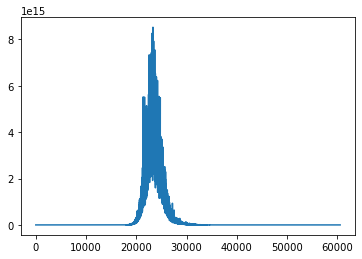

In [192]:
plt.plot(v_loss)

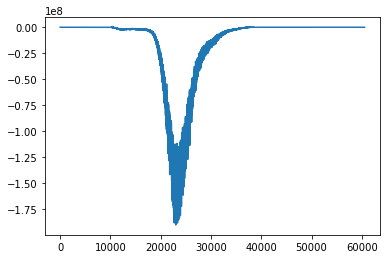

In [193]:
plt.plot(p_loss)

## 6. Testing

In [58]:
#Getting Cosine similarity of recommended items for a particular userid that has been evaluated
# from sklearn.metrics.pairwise import cosine_similarity as cs
# import seaborn as sns

def get_cosine_sim(userid):
    test_pred = test_pred_dict[userid]
    for i,item in enumerate(users_dict[userid]["item"]):
        if item in test_pred:
            print(item,":",users_dict[userid]["rating"][i])

    test_embed = []
    for item in test_pred:
        test_embed.append(np.array(item_embeddings_dict[int(item)]))

    test_embed_array = np.array(test_embed)

    return test_embed_array

test_embed_array = get_cosine_sim(userid_b[0])
ax = sns.heatmap(cs(test_embed_array), linewidth=0.5)
plt.show()


NameError: name 'test_pred_dict' is not defined

In [ ]:
#prediction algorithm
it2 = iter(test_dataloader)
precision = 0
test_pred_dict = dict()
for j in range(len(test_dataloader)-1):  #session 돌리기 : timestamps 내에서 items들 
    first = next(it2)
    item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
    memory[idx_b] = [item[0] for item in item_b]
    state = drrave_state_rep(userid_b,item_b,memory,idx_b)
    count = 0
    test_pred = set()
    for j in range(5):  #policy network5번 돌리기 , 추천 5번 하기
        state_rep =  torch.reshape(state,[-1])
        action_emb = policy_net(state_rep)   # policy_net = actor : items들의 선호도 (rating)
        action = get_action(state,action_emb,userid_b,item_b,test_pred)
        rate = int(users_dict[userid_b[0]]["rating"][action])
        try:
            rating = (int(rate)-3)/2
        except:
            rating = 0
        reward = torch.Tensor((rating,))

        if reward > 0:
            count += 1
            update_memory(memory,int(users_dict[userid_b[0]]["item"][action]),idx_b)
        next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
        state = next_state
    precision += count/5
    test_pred_dict[userid_b[0]] = test_pred
print("p",precision/(len(test_dataloader)-1))

## 7. Saving and Loading Models

In [ ]:
PATH = '/content/gdrive/My Drive/RLProject/Models/drravepolicy_net.pth'
torch.save(policy_net.state_dict(), PATH)

In [ ]:
value_PATH = '/content/gdrive/My Drive/RLProject/Models/drravevalue_net.pth'
torch.save(value_net.state_dict(), value_PATH)

tpolicy_PATH = '/content/gdrive/My Drive/RLProject/Models/drravetpolicy_net.pth'
torch.save(target_policy_net.state_dict(), tpolicy_PATH)

tvalue_PATH = '/content/gdrive/My Drive/RLProject/Models/drravetvalue_net.pth'
torch.save(target_value_net.state_dict(), tvalue_PATH)

In [ ]:
np.save('/content/gdrive/My Drive/RLProject/Models/train_dataloader',train_dataloader)
np.save('/content/gdrive/My Drive/RLProject/Models/test_dataloader',test_dataloader)

In [ ]:
policy_net = Actor(5500,100,256)
policy_net.load_state_dict(torch.load(PATH))
policy_net.eval()

value_net = Critic(5500,100,256)
value_net.load_state_dict(torch.load(value_PATH))
value_net.eval()

target_policy_net = Actor(5500,100,256)
target_policy_net.load_state_dict(torch.load(tpolicy_PATH))
target_policy_net.eval()

target_value_net = Critic(5500,100,256)
target_value_net.load_state_dict(torch.load(tvalue_PATH))
target_value_net.eval()


In [ ]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

train_data = np.load('/content/gdrive/My Drive/RLProject/Models/train_users.npy')

In [ ]:
np.load = np_load_old